<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#import-libs" data-toc-modified-id="import-libs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>import libs</a></span></li><li><span><a href="#Train-NN" data-toc-modified-id="Train-NN-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Train NN</a></span><ul class="toc-item"><li><span><a href="#main():-classifier" data-toc-modified-id="main():-classifier-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>main(): classifier</a></span></li><li><span><a href="#main():-regressor" data-toc-modified-id="main():-regressor-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>main(): regressor</a></span><ul class="toc-item"><li><span><a href="#Plot" data-toc-modified-id="Plot-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Plot</a></span></li></ul></li><li><span><a href="#test-example:-2d" data-toc-modified-id="test-example:-2d-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>test example: 2d</a></span><ul class="toc-item"><li><span><a href="#fully-connected-in-sklearn" data-toc-modified-id="fully-connected-in-sklearn-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>fully connected in sklearn</a></span></li><li><span><a href="#fully-connected-in-keras" data-toc-modified-id="fully-connected-in-keras-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>fully connected in keras</a></span></li><li><span><a href="#cnn" data-toc-modified-id="cnn-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>cnn</a></span></li></ul></li></ul></li></ul></div>

# import libs

In [2]:
import configparser
confParser = configparser.ConfigParser()

#--- parse conf. file
confParser.read('configuration.ini')
print('conf. file sections:',confParser.sections())

#--- system libs
import os
import sys
list(map(lambda x:sys.path.append(x), confParser['input files']['lib_path'].split()))
# from dscribe.descriptors import SOAP, ACSF
# import ase
# import ase.io
# import ase.build
# from ase.io import lammpsdata
import pdb
import time
import numpy as np
import pandas as pd
import traceback
import matplotlib.pyplot as plt
if not eval(confParser['flags']['RemoteMachine']):
    plt.rc('text', usetex=True)
import pickle

#--- sklearn
import sklearn
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.preprocessing import StandardScaler
#
from scipy.stats import gaussian_kde

#--- tensorflow
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# PyTorch geometric
import torch_geometric
import torch_geometric.data as geom_data
import torch_geometric.nn as geom_nn
from torch_geometric.data import Data, DataLoader

# PL callbacks
#from lightning.pytorch.callbacks import ModelCheckpoint
from torch import Tensor

#--- user modules
import LammpsPostProcess as lp
import utility as utl
import imp
imp.reload(utl)
imp.reload(lp)

#--- increase width
#from IPython.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

conf. file sections: ['flags', 'input files', 'descriptors', 'neural net', 'neural net classification', 'neural net regression', 'gnn', 'NeuralNets', 'ml mc']


/opt/anaconda3/envs/gnnEnv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'LammpsPostProcess' from '../../HeaDef/postprocess/LammpsPostProcess.py'>

# Train NN

In [2]:
class NeuralNetwork():

    def __init__(self, verbose=False,
                **kwargs
                ):
        self.verbose = verbose
        for key in kwargs:
            setattr(self,key,kwargs[key])
            
            
        !mkdir $self.best_model

    
    def Parse(self,path,nruns):
        self.perAtomData = {}
        rwjs = utl.ReadWriteJson()
        for irun in range(nruns):
            if irun == 0:
                #--- same configurations!
                self.descriptors  = np.c_[rwjs.Read('%s/Run%s/descriptors.json'%(path,irun))[0]['data']]
                self.shape        = np.c_[rwjs.Read('%s/Run%s/descriptors.json'%(path,irun))[0]['shape']].flatten()
                self.positions    = np.c_[rwjs.Read('%s/Run%s/descriptors.json'%(path,irun))[0]['xyz']]
                os.system('ln -s %s/Run%s/dumpFile/dump.xyz .'%(path,irun))
            try:
                data = np.loadtxt('%s/Run%s/perAtomData.txt'%(path,irun))
                #--- displacement data
                self.perAtomData[irun] = pd.DataFrame(np.c_[data],
                columns='id	type	x	y	z	ux	uy	uz	energy_barrier	defect_label'.split()
                            )
            except:
#                 if self.verbose:
#                     traceback.print_exc()
                continue
                
        
        self.nruns = list(self.perAtomData.keys())
        self.nruns.sort()

#     def Junk(self,path,nruns):
#         self.perAtomData = {}
#         self.Descriptors = {}
#         self.Shape       = {}
#         self.Positions   = {}
#         self.Catalogs    = {}
#         #
#         rwjs = utl.ReadWriteJson()
#         for irun in range(nruns):
#             try:
# #                 data_json               = rwjs.Read('%s/Run%s/descriptors.json'%(path,irun))[0]
# #                 self.Descriptors[irun]  = np.c_[data_json['data']]
# #                 self.Shape[irun]        = np.c_[data_json['shape']].flatten()
# #                 self.Positions[irun]    = np.c_[data_json['xyz']]
#                 os.system('ln -s %s/Run%s/dumpFile/dump.xyz ./dump.%s.xyz'%(path,irun,irun))
#                 data                    = np.loadtxt('%s/Run%s/perAtomData.txt'%(path,irun))
#                 self.perAtomData[irun]  = pd.DataFrame(np.c_[data],
#                                                        columns ='id type x y z'.split()
#                                                       )
#                 self.Catalogs[irun]     = pd.read_csv('%s/Run%s/catalog.txt'%(path,irun))
#             except:
# #                 if self.verbose:
# #                     traceback.print_exc()
#                 continue
                
        
#         self.nruns     = list(self.perAtomData.keys())
#         self.nruns.sort()

#         self.Descriptors[ 0 ] = pd.DataFrame(np.random.random(size=9876))
#         #--- assert shape and positions are the same for all realizations
# #         self.shape     = self.Shape[ self.nruns[ 0 ] ]
# #         self.positions = self.Positions[ self.nruns[ 0 ] ]

        
        
    def Parse2nd(self,path,nruns):
        self.perAtomData = {}
        self.Descriptors = {}
        self.Shape       = {}
        self.Positions   = {}
        self.Catalogs    = {}
        #
        rwjs = utl.ReadWriteJson()
        for irun in range(nruns):
            try:
                data_json               = rwjs.Read('%s/Run%s/descriptors.json'%(path,irun))[0]
                self.Descriptors[irun]  = np.c_[data_json['data']]
                self.Shape[irun]        = np.c_[data_json['shape']].flatten()
                self.Positions[irun]    = np.c_[data_json['xyz']]
                os.system('ln -s %s/Run%s/dumpFile/dump.xyz ./dump.%s.xyz'%(path,irun,irun))
                data                    = np.loadtxt('%s/Run%s/perAtomData.txt'%(path,irun))
                self.perAtomData[irun]  = pd.DataFrame(np.c_[data],
                                                       columns ='id type x y z'.split()
                                                      )
                self.Catalogs[irun]     = pd.read_csv('%s/Run%s/catalog.txt'%(path,irun))
            except:
#                 if self.verbose:
#                     traceback.print_exc()
                continue
                
        
        self.nruns     = list(self.perAtomData.keys())
        self.nruns.sort()

        #--- assert shape and positions are the same for all realizations
        self.shape     = self.Shape[ self.nruns[ 0 ] ]
        self.positions = self.Positions[ self.nruns[ 0 ] ]
        
    def Combine(self):
        
        if self.verbose:
            print('concatenating descriptors ...')
#         pdb.set_trace()
        #--- center atoms
        center_atom_indices = list(map(lambda x:NeuralNetwork.GetCenterAtom( self.perAtomData[x])[0],self.nruns))
        sdict = dict(zip(center_atom_indices,self.nruns))
        
        atom_ids = list(sdict.keys())
        atom_ids.sort()
        #         center_atom_indices = list( set( center_atom_indices ) )
        data = np.concatenate(list(map(lambda x: np.c_[self.perAtomData[sdict[x]].iloc[ x ]],atom_ids)),axis=1).T
#        descriptors_center_atoms = self.descriptors[atom_ids]
        descriptors_center_atoms = np.c_[list(map(lambda x:self.Descriptors[sdict[x]][x], atom_ids))]
    
        #--- data frame
#        print(data.shape)
        irun = self.nruns[0]
        df_combined = pd.DataFrame(data,columns=list(self.perAtomData[irun].keys()))
    
        #--- filter crystalline atoms
        filtr = self.perAtomData[irun].defect_label == 0.0
        df_crystalline = self.perAtomData[irun][filtr]
        descriptors_crystalline = self.descriptors[filtr]

        #--- merge
        keys = list(df_combined.keys())
        data_concat = np.concatenate([np.c_[df_combined[keys]],np.c_[df_crystalline[keys]]],axis=0) 
        self.perAtomData = pd.DataFrame(data_concat,
                              columns=keys
                             )

        
        #--- merge descriptors
        self.descriptors = np.concatenate([descriptors_center_atoms,descriptors_crystalline],axis=0)

        assert self.perAtomData.shape[ 0 ] == self.descriptors.shape[0], 'need more mc swaps: %s %s'\
        %(self.perAtomData.shape[ 0 ],self.descriptors.shape[0])
                            
    def Combine2nd(self):
        
        if self.verbose:
            print('concatenating descriptors ...')
            
        irun = self.nruns[0]
        keys = list( self.perAtomData[ irun ].keys() )

        #--- center atoms
        data_concat         = np.concatenate(list(map(lambda x: np.c_[self.perAtomData[x]],self.nruns)),axis=0)
        self.perAtomData    = pd.DataFrame(data_concat,
                                 columns=keys
                                )
        self.descriptors    = np.concatenate(list(map(lambda x:self.Descriptors[x], self.nruns)))
    
#     def Junk2nd(self):
        
#         if self.verbose:
#             print('concatenating descriptors ...')
            
#         irun = self.nruns[0]
#         keys = list( self.perAtomData[ irun ].keys() )

#         #--- center atoms
#         data_concat         = np.concatenate(list(map(lambda x: np.c_[self.perAtomData[x]],self.nruns)),axis=0)
#         self.perAtomData    = pd.DataFrame(data_concat,
#                                  columns=keys
#                                 )
#         self.descriptors    = None #self.Descriptors[0]

    def Parse3rd(self,path,nruns):

        self.Catalogs    = {}
        self.transition_paths = []
        self.transition_paths_discretized = []
        #
        rwjs = utl.ReadWriteJson()
        for irun in range(nruns):
            try:
                self.transition_paths.extend( rwjs.Read('%s/Run%s/saved_output/transition_paths.json'%(path,irun)) )
                self.transition_paths_discretized.extend( rwjs.Read('%s/Run%s/saved_output/transition_paths_discretized.json'%(path,irun)) )
                os.system('ln -s %s/Run%s/dumpFile/dump.xyz ./dump.%s.xyz'%(path,irun,irun))
                self.Catalogs[irun]     = pd.read_csv('%s/Run%s/saved_output/catalog.txt'%(path,irun))
            except:
#                 if self.verbose:
#                     traceback.print_exc()
                continue
                
        
        self.nruns     = list(self.Catalogs.keys())
        self.nruns.sort()
        
    def DataBuilder( self ):
        
        ntrain        = self.ntrain
        num_snapshots = len( self.transition_paths )
        snapshots     = range(num_snapshots)
        input_data    = [torch.from_numpy( np.c_[pd.DataFrame(self.transition_paths[ i ])['x y z'.split()]] ).float() for i in snapshots]  

        # Example target data (displacement vectors for each snapshot and each path)
        target_displacements = [torch.from_numpy( np.c_[pd.DataFrame(self.transition_paths[ i ])['ux_fin uy_fin uz_fin'.split()]] ).float() for i in snapshots]

        # Augment the dataset to have order 100 snapshots
        augmented_input_data = []
        augmented_target_displacements = []
        input_data_tensor = torch.stack(input_data)
        ntrain_initial = input_data_tensor.shape[0]*input_data_tensor.shape[1]
        n_repeat = np.max([1,int(ntrain/ntrain_initial)])

        for _ in range(n_repeat):  # Repeat the augmentation process 10 times
            augmented_input, augmented_target = GraphNet.augment_data(input_data, target_displacements, self.noise_std)
            augmented_input_data.extend(augmented_input)
            augmented_target_displacements.extend(augmented_target)

        adj_matrices = torch.stack(GraphNet.compute_adjacency_matrices(augmented_input_data, rcut=3.0)) 



        # Concatenate input data along a new dimension to form a single tensor
        input_data_tensor = torch.stack(augmented_input_data)
#        print('input_data_tensor.shape:',input_data_tensor.shape)

        # Standardize the augmented input data
        mean = input_data_tensor.mean(dim=(0, 1))
        std = input_data_tensor.std(dim=(0, 1))
        standardized_input_data = [GraphNet.standardize_data(data, mean, std) for data in augmented_input_data]


        # Convert input data to tensors
        target_displacements_tensor = torch.stack(augmented_target_displacements)




        # Concatenate nodes and edges for each graph
        graphs = []
        for i in range(len(input_data)):
            x = input_data_tensor[i]  # Node features
            edge_index = adj_matrices[i].nonzero().t()  # Edge indices
            y = target_displacements_tensor[i]  # Target displacements

            # Create a Data object for each graph
            data = Data(x=x, edge_index=edge_index, y=y)
            graphs.append(data)
            
        # Create a single large graph by concatenating Data objects
        large_graph = torch_geometric.data.Batch.from_data_list(graphs)

        # Define batch size and create DataLoader
        batch_size = len(input_data)
#        loader = DataLoader(large_graph, batch_size=batch_size, shuffle=True)
        
        # Define the split ratio (e.g., 80% for training, 20% for testing)
        train_ratio = 0.8

        # Define batch sizes for training and test dataloaders
        train_batch_size = int(batch_size * train_ratio)

        # Create DataLoader for training dataset
        loader = DataLoader(large_graph, batch_size=train_batch_size, shuffle=True)




        # Accessing batches in the DataLoader
        loader_iter=iter(loader)
        self.dataset_train = next(loader_iter)
        self.dataset_test = next(loader_iter)

        if self.verbose:
            print('dataset_train:',self.dataset_train)
            print('dataset_test:',self.dataset_test)
            
    
    @staticmethod
    def GetCenterAtom(df):
        disp_magnitude = df.ux**2+df.uy**2+df.uz**2
        center_atom_indx = disp_magnitude.sort_values(ascending=False).index[0]
        return center_atom_indx, int(df.iloc[ center_atom_indx ].id)

#     @staticmethod
#     def zscore(slist):
#         tmp = np.copy(slist)
#         print(np.mean(tmp),np.std(tmp))
#         tmp -= np.mean(tmp)
#         tmp /= np.std(tmp)
#         return tmp

    def PCA(self,
           n_components=2,
            random_state = 1,
           ):
        #--- concat. data
        X = self.descriptors
        pca = PCA(n_components=n_components,random_state=random_state)
        pca.fit(X)
        X_transformed = pca.transform(X)

        xdata = X_transformed[:,0]
        ydata = X_transformed[:,1]
        #
        filtr_defects = self.perAtomData.defect_label == 0.0
        #

        legend = utl.Legends()
        legend.Set(bbox_to_anchor=(1.1,.5, 0.5, 0.5))
#         pdb.set_trace()
        #ax = utl.PltErr(zscore(xdata)[filtr_defects],zscore(ydata)[filtr_defects],
        ax = utl.PltErr(xdata[filtr_defects],ydata[filtr_defects],
                  attrs={'fmt':'x','alpha':1,'label':'defect_free'},
                        Plot = False,
        #                 xlim=(-2,2),
        #                 ylim=(-2,2),
                  )

        #utl.PltErr(zscore(xdata)[~filtr_defects],zscore(ydata)[~filtr_defects],
        !mkdir png
        utl.PltErr(xdata[~filtr_defects],ydata[~filtr_defects],
                  attrs={'fmt':'.','color':'red','label':'defects'},
                   ax=ax,
                   xstr='pca_1',ystr='pca_2',
                   legend = legend.Get(),
                   title='png/pca.png'
                  )
    def Spectra(self,
               nrows=100,
               ):
        assert nrows <= self.descriptors.shape[ 0 ]
        !mkdir png
        utl.PltBitmap(np.log10(np.abs(self.descriptors[:nrows,:])),
                      xlabel=r'$\mathrm{ndim}$',ylabel=r'$\mathrm{natom}$',
                      xlim=(0,self.descriptors.shape[1]),
                      ylim=(0,nrows),
                      colorbar=True,
                      zscore=False,
                      vminmax=(-3,3),
                      title='png/feature_bitmap.png'
                     )
        
    def SklearnMLP(self,X_train,y_train):
        #-----------------------
        #--- parameter grid
        #-----------------------
#         param_grid = {
#                         'hidden_layer_sizes':self.hidden_layer_sizes,
#                          #'activation' : ['tanh', 'relu'],
#                          'learning_rate_init':self.learning_rate_init,
# #                         'alpha':self.alpha, #--- regularization 
#                          #'learning_rate' : ['invscaling', 'adaptive'],
#                         'n_iter_no_change':self.n_iter_no_change,
# #                        'tol':self.tol,
#                         'max_iter':self.max_iter,
#                      } 
        mlp   =  MLPClassifier(random_state=1,
                               hidden_layer_sizes = self.hidden_layer_sizes[0],
                               learning_rate_init = self.learning_rate_init[0],
                               n_iter_no_change   = self.n_iter_no_change[0],
                               max_iter           = self.max_iter[0],
                               verbose=self.verbose)
#         clf  =  GridSearchCV(mlp, param_grid)
#        clf.fit(X_train,y_train)
        mlp.fit(X_train,y_train)
        model =  mlp #clf.best_estimator_
        loss  =  model.loss_curve_
        val_loss = loss
        return (model, loss, val_loss)

    def KerasANN(self, X_train, y_train,X_test, y_test, ndime):

        model     = keras.Sequential([ #--- The network architecture
                                    layers.Dense(self.hidden_layer_size, activation=self.activation),
                #                    layers.Dense(self.hidden_layer_size, activation=self.activation),
                                    layers.Dense(ndime, activation='softmax')
                                    ])
        
#         shape         =  (self.shape[0]*self.shape[1]*self.shape[2],)
#         inputs        =  keras.Input(shape=shape)
#         #------------------------------
#         #--- The network architecture
#         #------------------------------
#         x             =  layers.Dense(   self.hidden_layer_size, activation=self.activation
#                                        )(inputs)
#         for i in range( self.number_hidden_layers ):
#             x       = layers.Dense( self.hidden_layer_size, activation=self.activation
#                                      )(x)
#         #--- output layer
# #         x       = layers.Flatten()(x)
#         outputs = layers.Dense( ndime, activation=self.activation)(x)
#         model   = keras.Model(inputs=inputs, outputs=outputs)

        
        
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=self.learning_rate_init) #--- compilation step
        model.compile( optimizer=optimizer,
                       loss="sparse_categorical_crossentropy",
                       metrics=["mse"]
                     )
        #--- save best model
        !mkdir best_model
#         callbacks=[keras.callbacks.ModelCheckpoint( filepath='best_model/convnetClassifier_from_scratch.tf',  
#                                                     monitor="mse",
#                                                     save_freq=10,
#                                                     save_best_only=True)]

        model.fit( X_train, y_train, 
           validation_data      = ( X_test, y_test ),
#             callbacks           = callbacks,
            epochs              = self.max_iter[0], 
            verbose             = self.verbose, 
            shuffle             = False, 
#             batch_size     = 32,
#                     use_multiprocessing = True,
#                     workers             = 4,
         )    

        model.save('best_model/convnetClassifier_from_scratch.tf')
        loss      = model.history.history['loss']
        val_loss  = model.history.history['val_loss']
        best_model = model #keras.models.load_model("best_model/convnetClassifier_from_scratch.tf")

        return (best_model, loss, val_loss)

    
    
    @staticmethod
    def MapClassIds( y ):
        ndime         = len(set(y.flatten()))
        class_ids     = list(set(y.flatten()))
        class_ids.sort()
        map_class_ids = dict(zip(class_ids,range(ndime)))        
        return ndime, np.c_[list(map(lambda x:[map_class_ids[x]],y.flatten()))]
    
    @staticmethod
    def GetSubSetCrystallineAtoms(X,y,n_train):
        #--- data frame
        df = pd.DataFrame( y, columns=['topoID'] )
        #--- groups
        sdict = df.groupby(by='topoID').groups
        if sdict[ 0 ].shape[ 0 ] < n_train:
            return X, y
        indices = np.random.choice(sdict[ 0 ], size=n_train, replace=False)
        sdict[ 0 ] = indices
        indices_total = np.concatenate( list(map(lambda x:sdict[x],sdict)) )
        return X[indices_total], y[ indices_total ]
    
    def GetLabels( self, irun ):
        nsize                                  = self.Descriptors[ irun ].shape[ 0 ]
        y_labels                               = np.zeros(nsize,dtype=int)
        nonCrystallineAtomsIndices             = self.Catalogs[ irun ].AtomIndex
        nonCrystallineAtomsTopoIds             = self.Catalogs[ irun ].IniTopoId.astype(int)
        y_labels[ nonCrystallineAtomsIndices ] = nonCrystallineAtomsTopoIds
        return y_labels.reshape( ( nsize, 1 ) )

    
    def TrainClassifier(self,
                       random_state=1,
                       ):
        
#         pdb.set_trace()

        #--- get labels
        y_labels = np.concatenate( list( map(lambda x:self.GetLabels(x), self.nruns ) ) )
        assert self.descriptors.shape[ 0 ] == y_labels.shape[ 0 ]
        
        #--- map topo ids to integers 0, 1 ... ndime
        ndime, y = NeuralNetwork.MapClassIds( y_labels )

        
        X      = np.c_[self.descriptors]

        #--- filter: only train a subset of crystalline atoms
        X, y   = NeuralNetwork.GetSubSetCrystallineAtoms( X, y, self.n_train )
        
        #---------------
        #--- zscore X
        #---------------        
        X      = NeuralNetwork.Zscore( X, save_model = '%s/classifier.sav'%self.best_model )

        #--- add noise
        NeuralNetwork.AddGaussianNoise(X, scale = 0.001 )


        #--- exclude void
#        filtr  = self.perAtomData.type==2
#         X      = X[~filtr]
#         y      = y[~filtr]

        #--- sample from crystalline atoms
        
        #-----------------------
        #--- train-test split
        #-----------------------
#        train_size = self.n_train
#        test_size  = int( self.n_train / 3 )
        assert X.shape[0] >= self.n_train, 'increase nruns!' #train_size + train_size, 'increase nruns!'
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
#                                                               test_size=test_size, train_size=train_size,
                                                              random_state=random_state)
        if len(set(y_train.flatten())) < ndime:
            'warning: not every class present in train set!'
        if len(set(y_test.flatten()))  < ndime: 
            'warning: not every class present in test set!'
        
        #-----------------------
        #--- train model
        #-----------------------
        if self.fully_connected: #--- dense nn
            if self.implementation == 'sklearn':
                (model, loss, val_loss) = self.SklearnMLP(X_train,y_train)
                classes_x = model.predict(X_test) 
                
            elif self.implementation == 'keras': #--- dense nn in keras
                (model, loss, val_loss) = self.KerasANN(X_train, y_train,X_test, y_test, ndime)
                predict_x = model.predict(X_test) 
                classes_x = np.argmax(predict_x,axis=1)
                
        elif self.cnn: #--- convolutional
            (model, loss, val_loss), (X_train, X_test) =\
            self.ConvNetworkClassifier( y )
            predict_x = model.predict(X_test) 
            classes_x = np.argmax(predict_x,axis=1)
                    
        #--- save loss data
        !mkdir png
        np.savetxt('png/val_loss_classification.txt',
                   np.c_[range(len(loss)),loss,val_loss],
                   header='epoch loss val_loss')

        #--- confusion matrix
        cm = confusion_matrix(y_test, classes_x,
                         labels=range(ndime)
                        )
        np.savetxt('png/confusion.txt',np.c_[cm])

        
    def PrintDescriptors(self,descriptors,y,fout):
        rwjs = utl.ReadWriteJson()
        rwjs.Write([{'descriptors':np.c_[descriptors],
                     'target':np.c_[y],
                     'shape_descriptor':self.shape}],fout)
        

    @staticmethod
    def GetTopoIds( catalog, key ): 
        TopoIds = list( catalog.groupby( by = key ).groups.keys())
        TopoIds.sort()
        return TopoIds 
    
    @staticmethod
    def MapTopoIds( TopoIds ):
        ndime         = len( TopoIds )
        map_TopoIds = dict(zip(TopoIds,range(ndime)))        
        return map_TopoIds

    def GetTopoArrayIndex( self, IniTopoId, FinTopoId ):
        mappedIniTopoId = self.mappedTopoIds[ IniTopoId ]
        mappedFinTopoId = self.mappedTopoIds[ FinTopoId ]
        assert mappedIniTopoId < self.n_unique_transition_paths and\
               mappedFinTopoId < self.n_unique_transition_paths 
        return mappedIniTopoId * self.n_unique_transition_paths * self.ndime + mappedFinTopoId * self.ndime

    def GetTopoArrayIndex2nd( self, ux, uy, uz ):
        aa = np.c_[[ux,uy,uz]].T
        H, bin_edges = np.histogramdd(aa,bins=self.bins)        
        assert H.sum() == 1.0
        
        return H.astype(int).flatten()
        

    def FillTargetMatrix( self, item ):
#        pdb.set_trace()
        ux = item.inifin_dr * item.DirX
        uy = item.inifin_dr * item.DirY
        uz = item.inifin_dr * item.DirZ
        assert np.abs( ux ) < self.umax and\
                np.abs( uy ) < self.umax and\
                np.abs( uz ) < self.umax,'ux=%e, uy=%e, uz=%e increase self.umax!'%(ux,uy,uz)
        irow                                   = int( item.AtomIndex )
#        icol                                   = int( self.GetTopoArrayIndex( item.IniTopoId, item.FinTopoId ) )
        H                                   = self.GetTopoArrayIndex2nd( ux, uy, uz )

        self.y_targets[ irow ] += H           

    def DiscretizeTransitionPath( self ):
         #--- hard-coded values
        xlin = np.arange(-self.umax,+self.umax+self.du,self.du)
        ylin = np.arange(-self.umax,+self.umax+self.du,self.du)
        zlin = np.arange(-self.umax,+self.umax+self.du,self.du)
        self.nbinx = len(xlin)-1
        self.nbiny = len(ylin)-1
        self.nbinz = len(zlin)-1
        self.bins = (xlin, ylin, zlin)
        self.xv, self.yv, self.zv = np.meshgrid( self.bins[1][:-1], self.bins[0][:-1], self.bins[2][:-1] )

#        print(yv[H==1],xv[H==1],zv[H==1])

    def GetTargets( self, irun ):
        #--- set-up y matrix
#         IniTopoId                              = NeuralNetwork.GetTopoIds( self.Catalogs[ irun ], 'IniTopoId' )
#         FinTopoId                              = NeuralNetwork.GetTopoIds( self.Catalogs[ irun ], 'FinTopoId' )
#         TopoIds                                = list( set( FinTopoId + IniTopoId ) ) #--- transition path ids
#         TopoIds.sort()
#         self.mappedTopoIds                     = NeuralNetwork.MapTopoIds( TopoIds )
        
#         self.n_unique_transition_paths         = len( TopoIds )


        nsize                                  = ( self.Descriptors[ irun ].shape[ 0 ], self.nbinx * self.nbiny * self.nbinz )
        self.y_targets                         = np.zeros( nsize[ 0 ] * nsize[ 1 ], dtype=int ).reshape( nsize )
        
        #--- fill y matrix
        self.Catalogs[ irun ].apply( lambda x: self.FillTargetMatrix( x ), axis = 1 )
        
        #--- assert self.y_targets is binary
        assert set(self.y_targets.flatten()) == set(np.array([0,1])), 'decrease du!'
        return self.y_targets
        
    def MaskCrystallineAtoms(self, irun ):
        nsize                              = self.Descriptors[ irun ].shape[ 0 ]
        mask                               = np.zeros(nsize,dtype=bool)
        nonCrystallineAtomsIndices         = np.array( list( set( self.Catalogs[ irun ].AtomIndex ) ) )
        mask[ nonCrystallineAtomsIndices ] = True
        return mask


    def GetInputOutput( self, irun, indx ):
        atomIndices     =  self.Catalogs[ irun ].AtomIndex
        pixel_map_input =  self.Descriptors[ irun ][ atomIndices ]    
        dr              =  np.c_[self.Catalogs[ irun ]['inifin_dr']].flatten()
        dr_multi        = np.c_[ dr, dr, dr ]
        vector_input    =  self.Catalogs[ irun ][ ' DirX      DirY      DirZ'.split() ] * dr_multi
        output          =  self.Catalogs[ irun ][ 'barrier' ]
        return [pixel_map_input, vector_input, output][ indx ]

    def TrainRegressorBarriers(self,
                       random_state=1,
                       ):
        '''
        Multi-layer Perceptron regressor.

        Parameters
        ----------
        stratify : array-like, default=None
        If not None, data is split in a stratified fashion, using this as
        the class labels.
        
        y : array-like, target data
        
        random_state : initial seed, default=1
        
        printOvito : bool, default=False
        
        filtr : bool, default=False
        if not None, data is filtered before calling train-test split
        '''

        
        #--- get transition path bitmap
#        self.DiscretizeTransitionPath()
#        self.ndime                                  = 4 #--- hard-coded: (ux,uy,uz,E)
        pixel_maps_input = np.concatenate( list( map(lambda x:self.GetInputOutput(x,0), self.nruns ) ) )
        vectors_input    = np.concatenate( list( map(lambda x:self.GetInputOutput(x,1), self.nruns ) ) )
        scalar_output    = np.concatenate( list( map(lambda x:self.GetInputOutput(x,2), self.nruns ) ) )

        
        #---------------
        #--- zscore X
        #---------------        
        X      = np.c_[pixel_maps_input,vectors_input]
        X      = NeuralNetwork.Zscore( X, save_model = '%s/scaler_regression_barriers.sav'%self.best_model )
        y      = np.c_[ scalar_output ]
        
        if X.shape[ 0 ] - self.n_train < 0 :  
            X = NeuralNetwork.Duplicate(X, new_size = self.n_train )
            y = NeuralNetwork.Duplicate(y, new_size = self.n_train )

        #--- add noise
        NeuralNetwork.AddGaussianNoise(X, scale = 0.01 )
        NeuralNetwork.AddGaussianNoise(y, scale = 0.01 )

        #-----------------------
        #--- train-test split
        #-----------------------
        X_train, X_test, y_train, y_test = train_test_split(X, y, #stratify=stratify,
                                                            random_state=random_state)


        #-----------------------
        #--- train model
        #-----------------------

                
        (model, loss, val_loss), (X_train, X_test) = self.ConvNetworkMixedInput(X_train, y_train, X_test, y_test )
            
            
            
            #--- validation
        NeuralNetwork.Validation(loss, val_loss, 
                                 model, 
                                 X_train, X_test, y_train, y_test)


    def TrainRegressorTransitionPaths(self,#stratify,y,
                       random_state=1,
                       printOvito = False,
 #                      filtr = None,
                       ):
        '''
        Multi-layer Perceptron regressor.

        Parameters
        ----------
        stratify : array-like, default=None
        If not None, data is split in a stratified fashion, using this as
        the class labels.
        
        y : array-like, target data
        
        random_state : initial seed, default=1
        
        printOvito : bool, default=False
        
        filtr : bool, default=False
        if not None, data is filtered before calling train-test split
        '''

        
        #--- get transition path bitmaps
        self.DiscretizeTransitionPath()
#        self.ndime                                  = 4 #--- hard-coded: (ux,uy,uz,E)
        y = np.concatenate( list( map(lambda x:self.GetTargets(x), self.nruns ) ) )

        
        #--- filtr crystalline atoms
        filtr = np.concatenate( list( map(lambda x:self.MaskCrystallineAtoms(x), self.nruns ) ) )

        y     = y[ filtr ]
        
#        pdb.set_trace()
        
        if self.verbose:
            print('dim(y)=',y.shape)

        ndime  = y.shape[1] #--- dimension of the target vector
        
        #---------------
        #--- zscore X
        #---------------        
        X      = np.c_[self.descriptors[filtr]]
        X      = NeuralNetwork.Zscore( X, save_model = '%s/scaler_regression.sav'%self.best_model )
        
        
        if X.shape[ 0 ] - self.n_train < 0 :  
            X = NeuralNetwork.Duplicate(X, new_size = self.n_train )
            y = NeuralNetwork.Duplicate(y, new_size = self.n_train )

        #--- add noise
        NeuralNetwork.AddGaussianNoise(X, scale = 0.1 )
#        NeuralNetwork.AddGaussianNoise(y, scale = 0.1 )

        #-----------------------
        #--- train-test split
        #-----------------------
        X_train, X_test, y_train, y_test = train_test_split(X, y, #stratify=stratify,
                                                            random_state=random_state)


        #-----------------------
        #--- train model
        #-----------------------
        if self.fully_connected: #--- dense nn
            if self.implementation == 'sklearn':
                #-----------------------
                #--- parameter grid
                #-----------------------
                param_grid = {
                                'hidden_layer_sizes':self.hidden_layer_sizes,
                                 #'activation' : ['tanh', 'relu'],
                                 'learning_rate_init':self.learning_rate_init,
                                'alpha':self.alpha, #--- regularization 
                                 #'learning_rate' : ['invscaling', 'adaptive'],
                                'n_iter_no_change':self.n_iter_no_change,
                                'tol':self.tol,
                                'max_iter':self.max_iter,
                             } 
                mlp   =  MLPRegressor(random_state=random_state,verbose=self.verbose) #--- mlp regressor
                regr  =  GridSearchCV(mlp, param_grid)
                regr.fit(X_train,y_train)
                model =  regr.best_estimator_
                loss  =  model.loss_curve_
                
            elif self.implementation == 'keras': #--- dense nn in keras
                model     = keras.Sequential([ #--- The network architecture
                    layers.Dense(self.hidden_layer_size, activation=self.activation),
#                    layers.Dense(self.hidden_layer_size, activation=self.activation),
                    layers.Dense(ndime, activation='softmax')
                    ])
                optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate_init) #--- compilation step
                model.compile( optimizer=optimizer,#"rmsprop",
                               loss="mean_squared_error",#"sparse_categorical_crossentropy",
                               metrics=["mse"]
                             )
                model.fit(X_train, y_train, #--- “Fitting”
                          validation_data=(X_test, y_test),
                          epochs=self.max_iter[0], verbose=self.verbose, batch_size=1)
                loss      = model.history.history['loss']
                val_loss  = model.history.history['val_loss']
                
        elif self.cnn: #--- convolutional
            
            (model, loss, val_loss), (X_train, X_test) =\
            self.ConvNetworkMultiLabelClassifier(X_train, y_train, X_test, y_test )
            
            NeuralNetwork.ValidationMultiLabelClassification(loss, val_loss, #--- validation
                                 model, 
                                 X_train, X_test, y_train, y_test)
            
#             pdb.set_trace()
#             (model, loss, val_loss), (X_train, X_test) =\
#             self.ConvNetwork(X_train, y_train, X_test, y_test )
            
            
            
            #--- validation
#             NeuralNetwork.Validation(loss, val_loss, 
#                                      model, 
#                                      X_train, X_test, y_train, y_test)
        
        #--- save in ovito file
#         if printOvito:
#             m = self.descriptors.shape[ 0 ]
#             indices = np.arange( m )[ filtr ]
        
#             if indices.shape[ 0 ] - self.n_train < 0 :  
#                 indices = NeuralNetwork.Duplicate(indices, new_size = self.n_train )
            
#             indices_train, indices_test, _, _ = train_test_split(indices, indices, #stratify=stratify,
#                                                                 random_state=random_state)
#             self.PrintOvito( indices_test, model )

    @staticmethod
    def Validation(loss, val_loss, model, X_train, X_test, y_train, y_test):
        #-----------------------
        #--- validation
        #-----------------------
        !mkdir png         #--- plot validation loss 
        ax = utl.PltErr(range(len(val_loss)), val_loss,
                   attrs={'fmt':'-'}, Plot=False,
                  )
        utl.PltErr(range(len(loss)), loss,
                   attrs={'fmt':'-'},
                   ax=ax,
                   yscale='log',xscale='log',
#                   xlim=(1,self.max_iter[0]),
                   xstr='epoch',ystr='loss',
                   title='png/loss.png',
                  )
        
        np.savetxt('png/loss.txt',np.c_[range(len(loss)),loss,val_loss],header='epoch loss val_loss')
        
        
        #--- plot predictions
        y_pred_test  = model.predict(X_test)        
        y_pred_train = model.predict(X_train)        
#         for idime, xstr in zip(range(3),'ux uy uz'.split()):
#             ax = utl.PltErr(None,None,Plot=False)
#             #
#             utl.PltErr(y_test[:,idime],y_pred_test[:,idime],
#                        attrs={'fmt':'x','color':'red','zorder':10,'markersize':6},
#                        ax=ax,
#                        Plot = False,

#                       )
#             #
#             utl.PltErr(y_train[:,idime],y_pred_train[:,idime],
#                        attrs={'fmt':'.','color':'blue','zorder':1,'markersize':6},
#                        ax=ax,
#                        Plot = False,

#                       )
#             #
#             utl.PltErr(None,None,Plot=False,
#                            title='png/scatter%s.png'%idime,
#                             ax=ax,
#                        xstr='%s actual'%xstr,ystr='%s predicted'%xstr,
#                        xlim=(-2,2),ylim=(-2,2),
#                            )

        #--- energy
        idime = 0 #3
        xstr  = 'energy'
        ax = utl.PltErr(None,None,Plot=False)
        #
        utl.PltErr(y_test[:,idime],y_pred_test[:,idime],
                   attrs={'fmt':'x','color':'red','zorder':10,'markersize':6},
                   ax=ax,
                   Plot = False,

                  )
        utl.PltErr(y_train[:,idime],y_pred_train[:,idime],
                   attrs={'fmt':'.','color':'blue','zorder':1,'markersize':6},
                   ax=ax,
                   Plot = False,

                  )
        #
        utl.PltErr(None,None,Plot=False,
                       title='png/scatter%s.png'%idime,
                        ax=ax,
                   xstr='%s actual'%xstr,ystr='%s predicted'%xstr,
#                   xlim=(-2,2),ylim=(-2,2),
                       )

    @staticmethod
    def ValidationMultiLabelClassification(loss, val_loss, model, X_train, X_test, y_train, y_test):
        #-----------------------
        #--- validation
        #-----------------------
        !mkdir png         #--- plot validation loss 
        ax = utl.PltErr(range(len(val_loss)), val_loss,
                   attrs={'fmt':'-'}, Plot=False,
                  )
        utl.PltErr(range(len(loss)), loss,
                   attrs={'fmt':'-'},
                   ax=ax,
                   yscale='log',xscale='log',
#                   xlim=(1,self.max_iter[0]),
                   xstr='epoch',ystr='loss',
                   title='png/lossMultiLabelClassification.png',
                  )
        
        np.savetxt('png/lossMultiLabelClassification.txt',np.c_[range(len(loss)),loss,val_loss],header='epoch loss val_loss')
        
        
        #--- plot predictions
        y_pred_test              = model.predict(X_test)        
        y_pred_train             = model.predict(X_train)
        
        threshold                = 0.5 #--- hard-coded threshold
        binary_predictions_test  = (y_pred_test > threshold).astype(int)
        binary_predictions_train = (y_pred_train > threshold).astype(int)
        binary_actual_test       = (y_test > threshold).astype(int)
        binary_actual_train      = (y_train > threshold).astype(int)

        
        
        #--- Compute the multilabel confusion matrix
        conf_matrix = multilabel_confusion_matrix( binary_actual_test, binary_predictions_test )
        ndime       = conf_matrix.shape[ 1 ] * conf_matrix.shape[ 2 ]
        conf_matrix = conf_matrix.reshape((conf_matrix.shape[0],ndime))
        np.savetxt('png/confusionMultiLabelClassification.txt',np.c_[conf_matrix])
        
        
        #--- predict displacements
        #--- reshape y_pred
        
            
        
#         disps_predictions_test = np.concatenate([list(map(lambda x: self.GetDispsFromBinaryMaps( x ) , binary_predictions_test ))])
#         disps_actual_test      = np.concatenate([list(map(lambda x: self.GetDispsFromBinaryMaps( x ) , binary_actual_test ))])
        
# #         #--- plot predictions
# #         y_pred_test  = model.predict(X_test)        
# #         y_pred_train = model.predict(X_train)        
#         for idime, xstr in zip(range(3),'ux uy uz'.split()):
#             ax = utl.PltErr(None,None,Plot=False)
#             #
#             utl.PltErr(disps_actual_test[:,idime],disps_predictions_test[:,idime],
#                        attrs={'fmt':'x','color':'red','zorder':10,'markersize':6},
#                        ax=ax,
#                        Plot = False,

#                       )
#             #
# #             utl.PltErr(y_train[:,idime],y_pred_train[:,idime],
# #                        attrs={'fmt':'.','color':'blue','zorder':1,'markersize':6},
# #                        ax=ax,
# #                        Plot = False,

# #                       )
#             #
#             utl.PltErr(None,None,Plot=False,
#                            title='png/scatter%s.png'%idime,
#                             ax=ax,
#                        xstr='%s actual'%xstr,ystr='%s predicted'%xstr,
#                        xlim=(-3,3),ylim=(-3,3),
#                            )

    def GetDispsFromBinaryMaps( self, binaryMap ):
        binaryMapReshaped = binaryMap.reshape((self.nbinx, self.nbiny, self.nbinz ))
        filtr = binaryMapReshaped == 1
        return np.c_[self.yv[filtr],self.xv[filtr],self.zv[filtr]]

        
    def PrintOvito( self, filtr, model ):
        #--- save in ovito
        X          = np.c_[self.descriptors[filtr]]
        X          = NeuralNetwork.Zscore( X )
        X_reshaped =  X.reshape((X.shape[0],self.shape[0],self.shape[1],self.shape[2],1))
        y_pred     = model.predict( X_reshaped )
        with open('original.xyz','w') as fp:
            utl.PrintOvito(self.perAtomData.iloc[filtr], fp, '0', attr_list='id type x y z ux uy uz'.split())
        with open('test.xyz','w') as fp:
            xyz = self.perAtomData.iloc[filtr]['id type x y z'.split()]
            cordc = pd.DataFrame(np.c_[xyz,y_pred[:,:3]],columns='id type x y z ux uy uz'.split())
            utl.PrintOvito(cordc, fp, '0', attr_list='id type x y z ux uy uz'.split())
                

    def ConvNetworkMixedInput(self,X_train, y_train, X_test, y_test):
        '''
        Convolutional neural network.

        Parameters
        ----------
        X_train : array-like training x input
        
        y_train : array-like, training y input
        
        X_test : array-like test x input
        
        y_test : array-like, training y input

        Return
        ---------- ( , loss,  )
        best_model : cnn object, best trained model based on on the validation loss
        
        loss : array-like, mse loss

        val_loss : array-like, validation loss

        '''
#         tf.random.set_random_seed(812)

        shape         =  (self.shape[0],self.shape[1],self.shape[2],1) #--- rows, cols, thickness, channels: pixel map
        shape_vector_input = 3
        
        kernel_size   =  self.kernel_size 
        epochs        =  self.max_iter[0]
        activation    =  self.activation
        padding       = 'same'
        filters       =  self.n_channels
        learning_rate = self.learning_rate_init[0]
        #
        ndime         =  y_train.shape[1]
        n_train       =  X_train.shape[0]
        n_test        =  X_test.shape[0]
        assert        shape[0] * shape[1] * shape[2] == X_train.shape[ 1 ] - shape_vector_input
        pixel_map_input        =  keras.Input(shape=shape)
        vector_input           =  keras.Input(shape=(shape_vector_input,))
        #

        #------------------------------
        #--- The network architecture
        #------------------------------
        x             =  layers.Conv3D(   filters     =  filters, 
                                          kernel_size =  kernel_size,
                                          activation  =  activation,
                                          padding     =  padding
                                       )(pixel_map_input)
        filters       *=  2
        for i in range( self.number_hidden_layers ):
            x       = layers.AveragePooling3D( pool_size = 2 )( x )
            x       = layers.Conv3D( filters       =  filters, 
                                     kernel_size   =  kernel_size,
                                     activation    =  activation,
                                     padding       =  padding
                                     )(x)
            filters *= 2
        x       = layers.Flatten()(x)
            
        #--- concatenate flattened map with vector
        combined = keras.layers.concatenate( [ x, vector_input ] )
        
        #--- output layer
        outputs = layers.Dense( ndime )( combined ) #, activation=activation)(x)
        model   = keras.Model(inputs=[pixel_map_input,vector_input], outputs=outputs)
        if self.verbose:
            print('cnn model summary:',model.summary())

        #--- The compilation step
        optimizer = tf.keras.optimizers.Adam( learning_rate = learning_rate )
        model.compile( optimizer =  optimizer,
                       loss      =  "mean_squared_error",
                       metrics   =  ["mse"]
                     )

        model.summary()
        #--- save best model
#         callbacks=[keras.callbacks.ModelCheckpoint( filepath='best_model/convnet_from_scratch.tf',  
#                                                    monitor="loss",
#                                                   save_freq=10,
#                                                     save_best_only=True)]

        #--- “Fitting” the model X_train_transfrmd, y_train
        nn = X_train.shape[ 1 ]
        X_train_pixels = X_train[:,0:nn-shape_vector_input]
        X_test_pixels  = X_test[:,0:nn-shape_vector_input]
        assert    X_train_pixels.shape[ 1 ] ==    shape[0] * shape[1] * shape[2]
        X_train_vector = X_train[:,nn-shape_vector_input:nn]
        X_test_vector  = X_test[:,nn-shape_vector_input:nn]
        assert    X_train_vector.shape[ 1 ] ==   shape_vector_input
        
    
        X_train_pixels =  X_train_pixels.reshape((n_train,shape[0],shape[1],shape[2],1))
        X_test_pixels  =  X_test_pixels.reshape((n_test,shape[0],shape[1],shape[2],1))
        
        model.fit( [X_train_pixels,X_train_vector], y_train, 
                   validation_data      = ( [X_test_pixels,X_test_vector], y_test ),
#                    callbacks            = callbacks,
                    epochs              = epochs, 
                    verbose             = self.verbose, 
                    shuffle             = False, 
#                    batch_size          = 1,
#                     batch_size     = 128,
#                     use_multiprocessing = True,
#                     workers             = 4,
                 )

        #--- validation loss
        model.save('best_model/convnetRegressorMixedInput_from_scratch.tf')
        loss       = model.history.history['loss']
        val_loss   = model.history.history['val_loss']
        best_model =model #keras.models.load_model("best_model/convnet_from_scratch.tf")

        
        return ( best_model, loss, val_loss ), ([X_train_pixels,X_train_vector], [X_test_pixels,X_test_vector])
    
    def ConvNetwork(self,X_train, y_train, X_test, y_test):
        '''
        Convolutional neural network.

        Parameters
        ----------
        X_train : array-like training x input
        
        y_train : array-like, training y input
        
        X_test : array-like test x input
        
        y_test : array-like, training y input

        Return
        ---------- ( , loss,  )
        best_model : cnn object, best trained model based on on the validation loss
        
        loss : array-like, mse loss

        val_loss : array-like, validation loss

        '''
#         tf.random.set_random_seed(812)

        shape         =  (self.shape[0],self.shape[1],self.shape[2],1) #--- rows, cols, thickness, channels
        kernel_size   =  self.kernel_size 
        epochs        =  self.max_iter[0]
        activation    =  self.activation
        padding       = 'same'
        filters       =  self.n_channels
        learning_rate = self.learning_rate_init[0]
        #
        ndime         =  y_train.shape[1]
        n_train       =  X_train.shape[0]
        n_test        =  X_test.shape[0]
        assert        shape[0] * shape[1] * shape[2] == X_train.shape[ 1 ]
        inputs        =  keras.Input(shape=shape)
        #

        #------------------------------
        #--- The network architecture
        #------------------------------
        x             =  layers.Conv3D(   filters     =  filters, 
                                          kernel_size =  kernel_size,
                                          activation  =  activation,
                                          padding     =  padding
                                       )(inputs)
        filters       *=  2
        for i in range( self.number_hidden_layers ):
            x       = layers.AveragePooling3D( pool_size = 2 )( x )
            x       = layers.Conv3D( filters       =  filters, 
                                     kernel_size   =  kernel_size,
                                     activation    =  activation,
                                     padding       =  padding
                                     )(x)
            filters *= 2
            
        #--- output layer
        x       = layers.Flatten()(x)
        outputs = layers.Dense( ndime )( x ) #, activation=activation)(x)
        model   = keras.Model(inputs=inputs, outputs=outputs)
        if self.verbose:
            print('cnn model summary:',model.summary())

        #--- The compilation step
        optimizer = tf.keras.optimizers.Adam( learning_rate = learning_rate )
        model.compile( optimizer =  optimizer,
                       loss      =  "mean_squared_error",
                       metrics   =  ["mse"]
                     )

        #--- save best model
#         callbacks=[keras.callbacks.ModelCheckpoint( filepath='best_model/convnet_from_scratch.tf',  
#                                                    monitor="loss",
#                                                   save_freq=10,
#                                                     save_best_only=True)]

        #--- “Fitting” the model X_train_transfrmd, y_train
        X_train_reshaped =  X_train.reshape((n_train,shape[0],shape[1],shape[2],1))
        X_test_reshaped  =  X_test.reshape((n_test,shape[0],shape[1],shape[2],1))
        model.fit( X_train_reshaped, y_train, 
                   validation_data      = ( X_test_reshaped, y_test ),
#                    callbacks            = callbacks,
                    epochs              = epochs, 
                    verbose             = self.verbose, 
                    shuffle             = False, 
#                    batch_size          = 1,
#                     batch_size     = 128,
#                     use_multiprocessing = True,
#                     workers             = 4,
                 )

        #--- validation loss
        model.save('best_model/convnetRegressor_from_scratch.tf')
        loss       = model.history.history['loss']
        val_loss   = model.history.history['val_loss']
        best_model =model #keras.models.load_model("best_model/convnet_from_scratch.tf")

        
        return ( best_model, loss, val_loss ), (X_train_reshaped, X_test_reshaped)
    
    def ConvNetworkMultiLabelClassifier(self,X_train, y_train, X_test, y_test):
        '''
        Convolutional neural network.

        Parameters
        ----------
        X_train : array-like training x input
        
        y_train : array-like, training y input
        
        X_test : array-like test x input
        
        y_test : array-like, training y input

        Return
        ---------- ( , loss,  )
        best_model : cnn object, best trained model based on on the validation loss
        
        loss : array-like, mse loss

        val_loss : array-like, validation loss

        '''
#         tf.random.set_random_seed(812)

        shape         =  (self.shape[0],self.shape[1],self.shape[2],1) #--- rows, cols, thickness, channels
        kernel_size   =  self.kernel_size 
        epochs        =  self.max_iter[0]
        activation    =  'relu' #self.activation
        padding       = 'same'
        filters       =  self.n_channels
        learning_rate = self.learning_rate_init[0]
        #
        ndime         =  y_train.shape[1]
        n_train       =  X_train.shape[0]
        n_test        =  X_test.shape[0]
        assert        shape[0] * shape[1] * shape[2] == X_train.shape[ 1 ]
        inputs        =  keras.Input(shape=shape)
        #

        #------------------------------
        #--- The network architecture
        #------------------------------
        x             =  layers.Conv3D(   filters     =  filters, 
                                          kernel_size =  kernel_size,
                                          activation  =  activation,
                                          padding     =  padding
                                       )(inputs)
        filters       *=  2
        for i in range( self.number_hidden_layers ):
            x       = layers.AveragePooling3D( pool_size = 2 )( x )
            x       = layers.Conv3D( filters       =  filters, 
                                     kernel_size   =  kernel_size,
                                     activation    =  activation,
                                     padding       =  padding
                                     )(x)
            filters *= 2
            
        #--- output layer
        x       = layers.Flatten()(x)
        outputs = layers.Dense( ndime, activation='sigmoid' )( x ) #, activation=activation)(x)
        model   = keras.Model(inputs=inputs, outputs=outputs)
        if self.verbose:
            print('cnn model summary:',model.summary())

        #--- The compilation step
        optimizer = tf.keras.optimizers.Adam( learning_rate = learning_rate )
        model.compile( optimizer =  optimizer,
                       loss      =  "binary_crossentropy",
                       metrics   =  ["mse"]
                     )

        #--- save best model
#         callbacks=[keras.callbacks.ModelCheckpoint( filepath='best_model/convnet_from_scratch.tf',  
#                                                    monitor="loss",
#                                                   save_freq=10,
#                                                     save_best_only=True)]

        #--- “Fitting” the model X_train_transfrmd, y_train
        X_train_reshaped =  X_train.reshape((n_train,shape[0],shape[1],shape[2],1))
        X_test_reshaped  =  X_test.reshape((n_test,shape[0],shape[1],shape[2],1))
        model.fit( X_train_reshaped, y_train, 
                   validation_data      = ( X_test_reshaped, y_test ),
#                    callbacks            = callbacks,
                    epochs              = epochs, 
                    verbose             = self.verbose, 
                    shuffle             = False, 
#                    batch_size          = 1,
#                     batch_size     = 128,
#                     use_multiprocessing = True,
#                     workers             = 4,
                 )

        #--- validation loss
        model.save('best_model/convnetMultiLabelClassifier_from_scratch.tf')
        loss       = model.history.history['loss']
        val_loss   = model.history.history['val_loss']
        best_model =model #keras.models.load_model("best_model/convnet_from_scratch.tf")

        
        return ( best_model, loss, val_loss ), (X_train_reshaped, X_test_reshaped)
    
    def ConvNetworkClassifier(self,y,
                               random_state=1
                               ):
        '''
        Convolutional neural network.

        Parameters
        ----------
        X_train : array-like training x input
        
        y_train : array-like, training y input
        
        X_test : array-like test x input
        
        y_test : array-like, training y input

        Return
        ---------- ( , loss,  )
        best_model : cnn object, best trained model based on on the validation loss
        
        loss : array-like, mse loss

        val_loss : array-like, validation loss

        '''
        
        if self.verbose:
            print('dim(y)=',y.shape)
        

        #---------------
        #--- zscore X
        #---------------        
        X      = np.c_[self.descriptors ]
        scaler = StandardScaler()
        scaler.fit(X)
        X      = scaler.transform( X )
    
        if self.verbose:
            print('X.shape:=',X.shape)
            
            
            
        #-----------------------
        #--- train-test split
        #-----------------------
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                            random_state=random_state)

        
        
        #---- set model parameters
        shape         =  (self.shape[0],self.shape[1],self.shape[2],1) #--- rows, cols, thickness, channels
        kernel_size   =  self.kernel_size 
        epochs        =  self.max_iter[0]
        activation    =  self.activation
        padding       = 'same'
        filters       =  self.n_channels
        learning_rate = self.learning_rate_init[0]
        #
        ndime         =  y_train.shape[1]
        n_train       =  X_train.shape[0]
        n_test        =  X_test.shape[0]
        assert        shape[0] * shape[1] * shape[2] == X_train.shape[ 1 ]
        inputs        =  keras.Input(shape=shape)

        #------------------------------
        #--- The network architecture
        #------------------------------
        x             =  layers.Conv3D(   filters     =  filters, 
                                          kernel_size =  kernel_size,
                                          activation  =  activation,
                                          padding     =  padding
                                       )(inputs)
        filters       *=  2
        for i in range( self.number_hidden_layers ):
            x       = layers.AveragePooling3D( pool_size = 2 )( x )
            x       = layers.Conv3D( filters       =  filters, 
                                     kernel_size   =  kernel_size,
                                     activation    =  activation,
                                     padding       =  padding
                                     )(x)
            filters *= 2
            
        #--- output layer
        x       = layers.Flatten()(x)
        outputs = layers.Dense( ndime, activation=activation)(x)
        model   = keras.Model(inputs=inputs, outputs=outputs)
        if self.verbose:
            print('cnn model summary:',model.summary())

        #--- The compilation step
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate) #--- compilation step
        model.compile( optimizer =  optimizer,
                       loss=["binary_crossentropy","sparse_categorical_crossentropy"][1],
                       metrics   =  ["mse"]
                     )

        #--- save best model
        !mkdir best_model
#         callbacks=[keras.callbacks.ModelCheckpoint( filepath='best_model/convnetClassifier_from_scratch.tf',  
#                                                     monitor="accuracy",
#                                                     save_freq=10,
#                                                     save_best_only=True)]

        #--- “Fitting” the model X_train_transfrmd, y_train
        X_train_reshaped =  X_train.reshape((n_train,shape[0],shape[1],shape[2],1))
        X_test_reshaped  =  X_test.reshape((n_test,shape[0],shape[1],shape[2],1))
        model.fit( X_train_reshaped, y_train, 
                   validation_data      = ( X_test_reshaped, y_test ),
                   callbacks            = callbacks,
                    epochs              = epochs, 
                    verbose             = self.verbose, 
                    shuffle             = False, 
#                     batch_size     = 128,
#                     use_multiprocessing = True,
#                     workers             = 4,
                 )

        #--- validation loss
        model.save('best_model/convnetClassifier_from_scratch.tf')
        loss       = model.history.history['loss']
        val_loss   = model.history.history['val_loss']
        best_model = model #keras.models.load_model("best_model/convnetClassifier_from_scratch.tf")

        
        return ( best_model, loss, val_loss ), (X_train_reshaped, X_test_reshaped)
    

    @staticmethod
    def Duplicate(X, new_size = 100 ):
        m = m0 = X.shape[ 0 ]
#        n = X.shape[ 1 ]
        augmented_x = np.copy( X )

        while m <= new_size:
            augmented_x = np.concatenate([augmented_x,X],axis = 0)
            #
            m = augmented_x.shape[ 0 ]

        assert m > new_size

        return augmented_x[:new_size]

    @staticmethod    
    def AddGaussianNoise(X,scale = 0.1):

        epsilon_x = np.random.normal(scale=scale,size=X.size).reshape(X.shape)
        X += epsilon_x
        
    
    def PrintDensityMap(self, atomIndx, irun, fout):
        with open(fout,'w') as fp:
                    disp           = np.c_[self.perAtomData[ irun ].iloc[atomIndx]['ux uy uz'.split()]].flatten()
                    df             = pd.DataFrame(np.c_[self.Positions[ irun ].T,self.Descriptors[ irun ][atomIndx]],
                                                  columns='x y z mass'.split())
                    utl.PrintOvito(df, fp, 'disp = %s'%disp, attr_list='x y z mass'.split())
                    
    @staticmethod
    def Zscore( X, **kwargs ):
        scaler = StandardScaler()
        scaler.fit(X)
        
        if 'save_model' in kwargs:
            pickle.dump( scaler, open( kwargs[ 'save_model' ], 'wb' ) )
        return scaler.transform( X )

#     def SaveConf(self,fout):
#         with open(fout,'w') as fp:
#             np.savetxt(fp,np.c_[self.perAtomData],header=' '.join(list(self.perAtomData.keys())))

#     def Test(self,y,
#                                    random_state=1
#                                    ):
#             '''
#             Convolutional neural network.

#             Parameters
#             ----------
#             X_train : array-like training x input

#             y_train : array-like, training y input

#             X_test : array-like test x input

#             y_test : array-like, training y input

#             Return
#             ---------- ( , loss,  )
#             best_model : cnn object, best trained model based on on the validation loss

#             loss : array-like, mse loss

#             val_loss : array-like, validation loss

#             '''

#             if self.verbose:
#                 print('dim(y)=',y.shape)

#             ndime  = y.shape[1] #--- dimension of the target vector


#             #---------------
#             #--- zscore X
#             #---------------        
#             X      = np.c_[self.descriptors ]
#             scaler = StandardScaler()
#             scaler.fit(X)
#             X      = scaler.transform( X )

#             if self.verbose:
#                 print('X.shape:=',X.shape)



#             #-----------------------
#             #--- train-test split
#             #-----------------------
#             X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
#                                                                 random_state=random_state)



#             #---- set model parameters
#             shape         =  (self.shape[0],self.shape[1],self.shape[2],1) #--- rows, cols, thickness, channels
#             kernel_size   =  self.kernel_size 
#             epochs        =  self.max_iter[0]
#             activation    =  self.activation
#             padding       = 'same'
#             filters       =  self.n_channels
#             learning_rate = self.learning_rate_init[0]
#             #
#             ndime         =  y_train.shape[1]
#             n_train       =  X_train.shape[0]
#             n_test        =  X_test.shape[0]
#             assert        shape[0] * shape[1] * shape[2] == X_train.shape[ 1 ]
#             inputs        =  keras.Input(shape=shape)
#             #
#     #         pdb.set_trace()
#             #------------------------------
#             #--- The network architecture
#             #------------------------------
#             model     = keras.Sequential([
#                 layers.Dense(self.hidden_layer_size, activation="relu"),
#     #             layers.Dense(self.hidden_layer_size), #activation="relu"),
#                 layers.Dense(2, activation="softmax")
#                 ])
#             optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate) #--- compilation step

#             model.compile( optimizer="rmsprop",
#                            loss="sparse_categorical_crossentropy",
#                            metrics=["mse"])


#             #--- “Fitting” the model X_train_transfrmd, y_train
#             X_train_reshaped =  X_train 
#             X_test_reshaped  =  X_test
#             model.fit( X_train_reshaped, y_train, 
#                        validation_data      = ( X_test_reshaped, y_test ),
#     #                     callbacks=callbacks,
#                         epochs              = epochs, 
#                         verbose             = self.verbose, 
#                         shuffle             = False, 
#     #                     batch_size     = 128,
#                         use_multiprocessing = True,
#                         workers             = 4,
#                      )        


#             #--- save best model
#             !mkdir best_model
#     #         callbacks=[keras.callbacks.ModelCheckpoint( filepath='best_model/convnetClassifier_from_scratch.tf',  
#     #                                                    monitor="val_loss",
#     #                                                   save_freq=10,
#     #                                                     save_best_only=True)]


#             #--- validation loss
#             loss       = model.history.history['loss']
#             val_loss   = model.history.history['val_loss']
#             best_model = model #keras.models.load_model("best_model/convnet_from_scratch.tf")


#             !mkdir png
#             utl.PltErr(range(len(loss)), loss,
#                        yscale='log',
#                        xstr='epoch',ystr='loss',
#                        title='png/loss_classification.png',
#                       )

#     #         pdb.set_trace()
#             #--- confusion matrix
#             cm = confusion_matrix(y_test, model.predict_classes(X_test),
#                              labels=[0, 1]
#                             )
#             print('cm=',cm)
#             np.savetxt('png/confusion.txt',np.c_[cm])


In [3]:
#nn.Catalogs[0]

## main(): classifier

In [4]:
 def main():
 
    if not eval(confParser['neural net classification']['classification']):
        return
    
    nn = NeuralNetwork(
                        hidden_layer_sizes   = eval(confParser['neural net classification']['hidden_layer_sizes']),
                        learning_rate_init   = eval(confParser['neural net classification']['learning_rate_init']),
                        n_iter_no_change     = eval(confParser['neural net classification']['n_iter_no_change']),
                        tol                  = eval(confParser['neural net classification']['tol']),
                        max_iter             = eval(confParser['neural net classification']['max_iter']),
                        alpha                = eval(confParser['neural net classification']['alpha']),
                        hidden_layer_size    = eval(confParser['neural net classification']['hidden_layer_size']),
                        fully_connected      = eval(confParser['neural net classification']['fully_connected']),
                        implementation       = eval(confParser['neural net classification']['implementation']),
                        cnn                  = eval(confParser['neural net classification']['cnn']),
                        n_channels           = eval(confParser['neural net classification']['n_channels']),
                        kernel_size          = eval(confParser['neural net classification']['kernel_size']),
                        activation           = eval(confParser['neural net classification']['activation']),
                        number_hidden_layers = eval(confParser['neural net classification']['number_hidden_layers']),
                        n_train              = eval(confParser['neural net classification']['n_train']),
                        best_model           = 'best_model',
                        verbose              = True 
                    )
    
    nn.Parse2nd( path  = confParser['neural net']['input_path'],
              nruns = eval(confParser['neural net classification']['nruns']))

    nn.Combine2nd() #--- concat. descriptors

    #--- classifier
    nn.TrainClassifier()
#        nn.Test(np.c_[nn.perAtomData.defect_label].astype(int))
    
    
    return nn

#model_clf = main()

## main(): regressor

In [5]:
 def main():
 
    if not eval(confParser['neural net regression']['regression']):
        return

    nn = NeuralNetwork(
                        hidden_layer_sizes   = eval(confParser['neural net regression']['hidden_layer_sizes']),
                        learning_rate_init   = eval(confParser['neural net regression']['learning_rate_init']),
                        n_iter_no_change     = eval(confParser['neural net regression']['n_iter_no_change']),
                        tol                  = eval(confParser['neural net regression']['tol']),
                        max_iter             = eval(confParser['neural net regression']['max_iter']),
                        alpha                = eval(confParser['neural net regression']['alpha']),
                        hidden_layer_size    = eval(confParser['neural net regression']['hidden_layer_size']),
                        fully_connected      = eval(confParser['neural net regression']['fully_connected']),
                        implementation       = eval(confParser['neural net regression']['implementation']),
                        cnn                  = eval(confParser['neural net regression']['cnn']),
                        n_channels           = eval(confParser['neural net regression']['n_channels']),
                        kernel_size          = eval(confParser['neural net regression']['kernel_size']),
                        activation           = eval(confParser['neural net regression']['activation']),
                        number_hidden_layers = eval(confParser['neural net regression']['number_hidden_layers']),
                        n_train              = eval(confParser['neural net regression']['n_train']),
                        du                   = eval(confParser['neural net regression']['du']),
                        umax                 = eval(confParser['neural net regression']['umax']),
                        best_model           = 'best_model',
                        verbose              = True 
                    )
    
    nn.Parse2nd( path  = confParser['neural net']['input_path'],
                 nruns = eval(confParser['neural net regression']['nruns'])
               )

    nn.Combine2nd() #--- concat. descriptors

    nn.TrainRegressorTransitionPaths()
    nn.TrainRegressorBarriers()
    
    return nn

#model_regr = main()

### Plot

In [6]:
def main():
    if eval(confParser['flags']['RemoteMachine']):
        return
    

    
    #--- ann
    number_hidden_layers  = dict(zip(range(4),[1]))
    hidden_layer_size     = dict(zip(range(4),[1]))
    n_channels            = dict(zip(range(4),[1]))
    activations           = dict(zip(range(20),['relu']))
#     string[ inums ] = "\t\'5\':\'neuralNet/20x20/ann/classifier/layer%s/channel%s/activation%s/layer_size%s\',\n" % (key_n,key_c,key_a,key_h) #--- change job name
    
    #--- cnn
#     number_hidden_layers  = dict(zip(range(4),[1,2,3]))
#     hidden_layer_size     = dict(zip(range(4),[1]))
#     n_channels            = dict(zip(range(4),[8,16,32,64]))
#     activations           = dict(zip(range(20),['linear']))

    runs = range(8)
    
    legend = utl.Legends()
    legend.Set(fontsize=14,bbox_to_anchor=(1.5, 0.3, 0.5, 0.5))
    symbols = utl.Symbols()
    
    nphi = len(number_hidden_layers)
    #---
    count = 0
    ax = utl.PltErr(None, None, Plot=False )
    for key_n in number_hidden_layers:
        number_hidden_layer = number_hidden_layers[key_n]
#         if number_hidden_layer != 2:
#             continue
        for key_c in n_channels:
            n_channel = n_channels[key_c]
#             if n_channel != 16:
#                 continue
            for key_a in activations:
                activation = activations[key_a]
                for key_h in hidden_layer_size:
                    nsize = hidden_layer_size[key_h]

        #---	
#                    path = 'neuralNet/20x20/cnn/classifier/layer%s/channel%s/activation%s/layer_size%s'%(key_n,key_c,key_a,key_h) #--- change job name
                    path = 'neuralNet/ni/interestitials/test2nd' #--- change job name
                    fp = ['confusion.txt', 'val_loss_classification.txt','loss.txt'][ 2 ]
                    for irun in runs:
                        try:
                            data = np.loadtxt('%s/Run%s/png/%s'%(path,irun,fp))
                        except:
                            continue

                        if fp == 'confusion.txt':
                            accuracy_crystals = data[0,0]/np.sum(data[0,:])
                            accuracy_defects = data[1,1]/np.sum(data[1,:])
                            print(data)
                            utl.PltErr(accuracy_crystals, accuracy_defects,
                               attrs=symbols.GetAttrs(count=count%7,nevery=800,
                                    label='%s layers, %s channels, act. %s'%(number_hidden_layer,n_channel,activation)), 
                                       Plot=False,
                                       ax=ax,
                                       )
                        else:
                            epoch = data[:,0]
                            loss = data[:,1]
                            val_loss = data[:,2]

                            utl.PltErr(epoch, loss,
                               attrs=symbols.GetAttrs(count=count%7,nevery=10,
                                    label='train:%s layers, %s channels, act. %s'%(number_hidden_layer,n_channel,activation)), 
                                       Plot=False,
                                       ax=ax,
                                       )
                            utl.PltErr(epoch, val_loss,
                               attrs=symbols.GetAttrs(count=(count+1)%7,nevery=10,
                                    label='test:%s layers, %s channels, act. %s'%(number_hidden_layer,n_channel,activation)), 
                                       Plot=False,
                                       ax=ax,
                                       )
                    count += 1
    ax = utl.PltErr(None, None,
                        yscale='log',xscale='log',
                       xstr='epoch',ystr='validation loss',
#                     ylim=(1e-1,1e1),
                    ax=ax,
                    legend=legend.Get(),
                       title='png/training_loss.png',
                   )


main()

In [7]:
# cm=np.loadtxt('neuralNet/ni/interestitials/test2nd/Run0/png/confusionMultiLabelClassification.txt').astype(int)
# falseNegative = list(map(lambda x: 1.0*x[0]/(x[0]+x[1]), cm))
# truePositive  = list(map(lambda x: 1.0*x[3]/(x[2]+x[3]), cm))
# filtr  = cm[:,3] > 0
# cm[filtr]

In [8]:
# legend = utl.Legends()
# legend.Set(fontsize=14,bbox_to_anchor=(1.5, 0.3, 0.5, 0.5))
# symbols = utl.Symbols()

# fp = ['confusion.txt', 'val_loss_classification.txt'][0]
# data = np.loadtxt('neuralNet/ni/kmc/inactive/Run0/png/%s'%(fp))
# ax = utl.PltErr(None, None, Plot=False )
# if fp == 'confusion.txt':
#     accuracy_crystals = data[0,0]/np.sum(data[0,:])
#     accuracy_defects = data[1,1]/np.sum(data[1,:])
#     print(data)
#     utl.PltErr(accuracy_crystals, accuracy_defects,
#        attrs=symbols.GetAttrs(count=0,nevery=800,
#             ), 
#                Plot=False,
#                ax=ax,
#                )
# else:
#     epoch = data[:,0]
#     loss = data[:,1]
#     val_loss = data[:,2]

#     utl.PltErr(epoch, val_loss,
#        attrs=symbols.GetAttrs(count=0,nevery=10,
#             ), 
#                Plot=False,
#                ax=ax,
#                )
    
# ax = utl.PltErr(None, None,
# yscale='log',xscale='log',
# xstr='epoch',ystr='validation loss',
# #                     ylim=(1e-1,1e1),
# ax=ax,
# # legend=legend.Get(),
# title='png/training_loss.png',
# )

## test example: 2d

In [9]:
# import numpy as np
# y=np.c_[[1.725966,1.725967],
#             [-1.725966,1.725967],
#             [-1.725966,-1.725967],
#             [1.725966,-1.725967],
#            ].T

# X=np.concatenate([list(map(lambda x:np.load('png/descriptor%s.npy'%x).flatten(),range(4)))],axis=1)

# #--- zscore
# scaler = StandardScaler()
# scaler.fit(X)
# X_transfrmd = scaler.transform( X )

# X_train_transfrmd, X_test_transfrmd, y_train, y_test = train_test_split(X_transfrmd, y, test_size=0.25)
# print(y_test)


# print(X_train_transfrmd.shape)

### fully connected in sklearn

In [10]:

# #        pdb.set_trace()
# #--- tune parameters

# #--- train
# mlp = MLPRegressor(random_state=1,
#                     verbose=True,
#                    n_iter_no_change=100000,
#                     max_iter=100,#00,
#                    hidden_layer_sizes=(1000,1000),
# #                    shuffle=False,
# #                     alpha=1e-1,

#                   )
# mlp.fit(X_train_transfrmd,y_train)

# #--- validate
# !mkdir png
# utl.PltErr(range(len(mlp.loss_curve_)), mlp.loss_curve_,
#            attrs={'fmt':'-'},
#            yscale='log',xscale='log',
# #           xlim=(1,self.max_iter[0]),
#            xstr='epoch',ystr='loss',
#            title='png/loss.png',
#           )

# # #         pdb.set_trace()
# y_pred =mlp.predict(X_test_transfrmd)        
# y_pred_train = mlp.predict(X_train_transfrmd)        
# for idime, xstr in zip(range(2),'ux uy'.split()):
#     ax = utl.PltErr(None,None,Plot=False)
#     #
#     utl.PltErr(y_test[:,idime],y_pred[:,idime],
#                attrs={'fmt':'x','color':'red','zorder':10,'markersize':6},
#                ax=ax,
#                Plot = False,

#               )
#     #
#     utl.PltErr(y_train[:,idime],y_pred_train[:,idime],
#                attrs={'fmt':'.','color':'blue','zorder':1,'markersize':6},
#                ax=ax,
#                Plot = False,

#               )
#     #
#     utl.PltErr(None,None,Plot=False,
#                    title='png/scatter%s.png'%idime,
#                     ax=ax,
#                xstr='%s actual'%xstr,ystr='%s predicted'%xstr,
#                xlim=(-3,3),ylim=(-3,3),
#                    )




In [11]:
# mlp.best_loss_, mlp.loss_

In [12]:
# ux,uy=mlp.predict(X_test_transfrmd)[0]
# ax=utl.PltErr([0,ux],[0,uy],
#               Plot=False
#           )
# utl.PltErr([0,y_test[0][0]],[0,y_test[0][1]],
#            xlim=(-3,3),ylim=(-3,3),
#             ax=ax
#           )

In [13]:
# ux,uy

In [14]:
# ax = utl.PltErr(None,None,Plot=False)

# for i in range(2):
#     utl.PltErr(range(data.descriptors[0,:].shape[0]),data.descriptors[i,:],
#               attrs={'fmt':'-'},#,'color':'C0'},
#                xscale='log',yscale='log',
#                ax=ax,
#                Plot=False,
#               )

# utl.PltErr(range(data.descriptors[100,:].shape[0]),data.descriptors[100,:],
#           attrs={'fmt':'-','color':'C0'},
#            xscale='log',yscale='log',
#            ax=ax,
#            Plot=False,
#           )


In [15]:
# data.Spectra(nrows=100)

In [16]:
# from sklearn.neural_network import MLPRegressor
# from sklearn.datasets import make_regression
# from sklearn.model_selection import train_test_split
# X, y = make_regression(n_samples=200, random_state=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                     random_state=1)
# regr = MLPRegressor(verbose=False,
#                     random_state=1, 
# #                     learning_rate='adaptive',
# #                    early_stopping=True, 
#                      n_iter_no_change=1, 
#                     tol=1e-2,
#                      max_iter=10000000,
# #                     solver='sgd',
#                    ).fit(X_train, y_train)
# regr.tol


### fully connected in keras

In [17]:
# #--- The network architecture
# model = keras.Sequential([
#     layers.Dense(512), #activation="relu"),
# #     layers.Dense(1000), #activation="relu"),
#     layers.Dense(2) #, activation="relu")
#     ])

# #--- The compilation step
# optimizer = tf.keras.optimizers.Adam() #learning_rate=1e-4)
# model.compile( optimizer=optimizer,#"rmsprop",
#                loss="mean_squared_error",#"sparse_categorical_crossentropy",
#                metrics=["mse"]
#              )

# #--- Preparing the image data
# # train_images = train_images.reshape((60000, 28 * 28))
# # train_images = train_images.astype("float32") / 255
# # test_images = test_images.reshape((10000, 28 * 28))
# # test_images = test_images.astype("float32") / 255

# #--- “Fitting” the model X_train_transfrmd,y_train
# model.fit(X_train_transfrmd, y_train, 
#             validation_data=(X_test_transfrmd, y_test),

#           epochs=100, verbose=False)#, batch_size=128)

# loss = model.history.history['loss']
# val_loss = model.history.history['val_loss']
# #--- validate

# ax = utl.PltErr(range(len(val_loss)), val_loss,
#            attrs={'fmt':'-'}, Plot=False,
#           )
# utl.PltErr(range(len(loss)), loss,
#            attrs={'fmt':'-'},
#            ax=ax,
#            yscale='log',xscale='log',
#            xlim=(1,100),
#            xstr='epoch',ystr='loss',
#            title='png/loss.png',
#           )

### cnn

In [18]:
# tf.random.set_random_seed(812)

# shape=(300,300,1)
# kernel_size = (3,3)
# epochs = 1000
# activation = ['linear','sigmoid','relu'][0]
# padding='same'
# filters = 1
# #
# ndime = y_train.shape[1]
# n_train = X_train_transfrmd.shape[0]
# n_test = X_test_transfrmd.shape[0]
# assert shape[0]*shape[1]*shape[2] == X_train_transfrmd.shape[1]
# inputs = keras.Input(shape=shape)
# #
# x = layers.Conv2D(filters=filters, kernel_size=kernel_size,activation=activation,padding=padding)(inputs)
# # x = layers.AveragePooling2D(pool_size=2)(x)
# # x = layers.Conv2D(filters=2*filters, kernel_size=kernel_size,activation=activation,padding=padding)(x)
# # x = layers.AveragePooling2D(pool_size=2)(x)
# # x = layers.Conv2D(filters=4*filters, kernel_size=kernel_size,activation=activation,padding=padding)(x)
# # x = layers.AveragePooling2D(pool_size=2)(x)
# # x = layers.Conv2D(filters=8*filters, kernel_size=kernel_size,activation=activation,padding=padding)(x)
# x = layers.Flatten()(x)
# outputs = layers.Dense( ndime, activation=activation)(x)

# #--- The network architecture
# model = keras.Model(inputs=inputs, outputs=outputs)

# print(model.summary())

# #--- The compilation step
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5,epsilon=1e-08)
# model.compile( optimizer=optimizer,#"rmsprop",
#                loss="mean_squared_error",#"sparse_categorical_crossentropy",
#                metrics=["mse"]
#              )

# #--- save best model 
# callbacks=[keras.callbacks.ModelCheckpoint( filepath='png/convnet_from_scratch.keras',  
#                                            monitor="val_loss",
#                                            save_freq=10,
#                                             save_best_only=True)]

# #--- “Fitting” the model X_train_transfrmd,y_train
# X_train_reshaped = X_train_transfrmd.reshape((n_train,shape[0],shape[1],1))
# X_test_reshaped = X_test_transfrmd.reshape((n_test,shape[0],shape[1],1))
# model.fit(X_train_reshaped, y_train, 
#             validation_data=(X_test_reshaped, y_test),
#             #callbacks=callbacks,
#           epochs=epochs, verbose=False, shuffle=False)#, batch_size=128)

# loss = model.history.history['loss']
# val_loss = model.history.history['val_loss']
# #--- validate

# ax = utl.PltErr(range(len(val_loss)), val_loss,
#            attrs={'fmt':'-'}, Plot=False,
#           )
# utl.PltErr(range(len(loss)), loss,
#            attrs={'fmt':'-'},
#            ax=ax,
#            yscale='log',xscale='log',
#            xlim=(1,epochs),
#            xstr='epoch',ystr='loss',
#            title='png/loss.png',
#           )

In [19]:
#best_model = keras.models.load_model("png/convnet_from_scratch.keras")


In [20]:
# ux,uy=best_model.predict(X_test_reshaped)[0]
# ax=utl.PltErr([0,ux],[0,uy],
#               Plot=False
#           )
# utl.PltErr([0,y_test[0][0]],[0,y_test[0][1]],
#            xlim=(-3,3),ylim=(-3,3),
#             ax=ax
#           )

In [21]:
# (ux,uy), y_test[0]

In [22]:
# rd = lp.ReadDumpFile( '%s/lammps_data.dat'%confParser['input files']['input_path'] )
# rd.ReadData()
# # box = 
# natoms = rd.coord_atoms_broken[ 0 ].shape[0]
# atom_indices = ' '.join(map(str,range(natoms)))

# fp = '%s/lammps_data.dat'%confParser['input files']['input_path']
# fout = 'neighbor_list.xyz'
# cutoff = 3.0
# lib_path = confParser['input files']['lib_path'].split()[0]
# #--- neighbor list
# os.system('ovitos %s/OvitosCna.py %s %s 1 6 %s %s'%(lib_path,fp,fout,cutoff,atom_indices))


# nl = lp.ReadDumpFile(fout)
# nl.GetCords()

In [23]:
# def GetIndex(dff, key, vals ):
# #    dff = rd.coord_atoms_broken[ 0 ]
#     dff['index'] = range(natoms)
#     indices = dff.set_index(key, drop = True, append=False, inplace= False).loc[vals]['index']
#     return np.c_[indices].flatten()



In [24]:
# import scipy
# from scipy.sparse import lil_matrix

# #--- adj matrix

# df_xyz = rd.coord_atoms_broken[ 0 ]
# df = nl.coord_atoms_broken[0]
# df
# center_ids = df.groupby(by='id').groups

# #--- sparse
# # Adj_mat = sparse_mat(natoms,natoms)
# Adj_mat_total = lil_matrix((natoms, natoms),dtype=int)

# for center_id in center_ids:
#     center_indx = GetIndex(df_xyz,'id',[center_id])[ 0 ]
#     neibor_ids  = df['J'].iloc[ center_ids[ center_id ] ].astype( int )
#     neibor_indices = GetIndex(df_xyz,'id',np.c_[neibor_ids].flatten())
#     Adj_mat_total[center_indx, neibor_indices ] = 1
# #     if Adj_mat_total[center_indx].sum() != 12:
# #         print('center_indx=%s'%center_indx)

# neural net

In [25]:
class NeuralNets:

    def __init__(self,confParser,verbose=True):
        self.ntrain               = eval(confParser['NeuralNets']['ntrain'])    
        self.noise_std            = eval(confParser['NeuralNets']['noise_std'])
        self.verbose              = verbose
        self.kernel_size          =  (3,3,3)
        self.max_iter             =  eval(confParser['NeuralNets']['max_iter'])
        self.activation           =  eval(confParser['NeuralNets']['activation'])
        self.n_channels           = 32
        self.learning_rate        = eval(confParser['NeuralNets']['learning_rate'])
        self.number_hidden_layers = eval(confParser['NeuralNets']['number_hidden_layers'])
            
    def Parse(self,path,nruns):

        self.Catalogs    = {}
        self.transition_paths = []
        self.transition_paths_atoms = []
        #
        rwjs = utl.ReadWriteJson()
        for irun in range(nruns):
            try:
                self.transition_paths.extend( rwjs.Read('%s/Run%s/saved_output/transition_paths_discretized.json'%(path,irun)) )
                self.transition_paths_atoms.extend( rwjs.Read('%s/Run%s/saved_output/transition_paths.json'%(path,irun)) )
                os.system('ln -s %s/Run%s/dumpFile/dump.xyz ./dump.%s.xyz'%(path,irun,irun))
                self.Catalogs[irun]     = pd.read_csv('%s/Run%s/saved_output/catalog.txt'%(path,irun))
            except:
#                 if self.verbose:
#                     traceback.print_exc()
                continue
                
        
        self.nruns     = list(self.Catalogs.keys())
        self.nruns.sort()
        
        self.shape = tuple(np.loadtxt('%s/Run%s/saved_output/shape.txt'%(path,0)).astype(int))
        
        
    def DataBuilder( self ):
        
        ntrain        = self.ntrain
        num_snapshots = len( self.transition_paths )
        snapshots     = range(num_snapshots)
        input_data    = [torch.from_numpy( np.c_[pd.DataFrame(self.transition_paths[ i ])['rho'.split()]] ).float() for i in snapshots]  

        # Example target data (displacement vectors for each snapshot and each path)
        target_displacements = [torch.from_numpy( np.c_[pd.DataFrame(self.transition_paths[ i ])['ux_fin uy_fin uz_fin'.split()]] ).float() for i in snapshots]

        # Augment the dataset to have order 100 snapshots
        augmented_input_data = []
        augmented_target_displacements = []
        input_data_tensor = torch.stack(input_data)
        ntrain_initial = input_data_tensor.shape[0]
        n_repeat = np.max([1,int(ntrain/ntrain_initial)])

        for _ in range(n_repeat):  # Repeat the augmentation process 10 times
            augmented_input, augmented_target = NeuralNets.augment_data(input_data, target_displacements, self.noise_std)
            augmented_input_data.extend(augmented_input)
            augmented_target_displacements.extend(augmented_target)




        # Concatenate input data along a new dimension to form a single tensor
        input_data_tensor = torch.stack(augmented_input_data)
#        print('input_data_tensor.shape:',input_data_tensor.shape)

        # Standardize the augmented input data
        mean = input_data_tensor.mean(dim=(0))
        std = input_data_tensor.std(dim=(0))
        standardized_input_data = ( input_data_tensor - mean ) / std
        assert torch.all(standardized_input_data.mean(dim=(0)).abs() < 1.0e-6 )
        assert torch.all((standardized_input_data.std(dim=(0)) - 1.0).abs() < 1.0e-6 )


        # Convert input data to tensors
        target_displacements_tensor = torch.stack(augmented_target_displacements)
        input_data_tensor           = standardized_input_data #torch.stack(standardized_input_data)


        X = input_data_tensor
        y = target_displacements_tensor
        
        X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                               test_size=test_size, train_size=train_size,
                                                              random_state=1)



        # Define batch sizes for training and test dataloaders
        self.dataset_train = {}
        self.dataset_test = {}
        self.dataset_train['x'] = X_train
        self.dataset_train['y'] = y_train
        self.dataset_test['x']  = X_test
        self.dataset_test['y']  = y_test


        if self.verbose:
            print('dataset_train:',self.dataset_train['x'].shape)
            print('dataset_test:',self.dataset_test['x'].shape)
            
    def CreateModel(self):
        shape         =  (self.shape[0], self.shape[1], self.shape[2], 1)  # Bitmap size 24x24x24 with 1 channel
        ndime         = 3
        kernel_size   =  self.kernel_size 
        activation    =  self.activation
        padding       = 'same'
        filters       =  self.n_channels
        inputs        =  keras.Input(shape=shape)

        #------------------------------
        #--- The network architecture
        #------------------------------
        x             =  layers.Conv3D(   filters     =  filters, 
                                          kernel_size =  kernel_size,
                                          activation  =  activation,
                                          padding     =  padding
                                       )(inputs)
        filters       *=  2
        for i in range( self.number_hidden_layers ):
            x       = layers.AveragePooling3D( pool_size = 2 )( x )
            x       = layers.Conv3D( filters       =  filters, 
                                     kernel_size   =  kernel_size,
                                     activation    =  activation,
                                     padding       =  padding
                                     )(x)
            filters *= 2

        #--- output layer
        x       = layers.Flatten()(x)
        
        # Fully connected layers
        x = layers.Dense( 256, activation=activation )( x )
        x = layers.Dense( 512, activation=activation )( x )
        x = layers.Dense( shape[0] * shape[1] * shape[2] * ndime )( x )
        outputs = layers.Reshape((shape[0], shape[1], shape[2], ndime))(x)
        model   = keras.Model(inputs=inputs, outputs=outputs)
        if self.verbose:
            print('cnn model summary:', model.summary())
            
            
        optimizer = tf.keras.optimizers.Adam( learning_rate = self.learning_rate )
        model.compile( optimizer =  optimizer,
                       loss      =  "mean_squared_error",
                       metrics   =  ["mse"]
                     )

        return model
            


    def autoencoder_3d(self):
        input_shape         =  (self.shape[0], self.shape[1], self.shape[2], 1)  # Bitmap size 24x24x24 with 1 channel
        ndime         = 3

        # Encoder
        inputs = keras.Input(shape=input_shape)
        x = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
        x = layers.MaxPooling3D((2, 2, 2), padding='same')(x)
        encoded = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(x)

        # Decoder
        x = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(encoded)
        x = layers.UpSampling3D((2, 2, 2))(x)
        decoded = layers.Conv3D(3, (3, 3, 3), activation='linear', padding='same')(x)

        # Autoencoder model
        autoencoder = keras.Model(inputs, decoded)
        optimizer = tf.keras.optimizers.Adam( learning_rate = self.learning_rate )
        autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

        if self.verbose:
            print('cnn model summary:', autoencoder.summary())
        return autoencoder




    def Training(self):
        '''
        Convolutional neural network.

        Return
        ---------- ( , loss,  )
        best_model : cnn object, best trained model based on on the validation loss

        loss : array-like, mse loss

        val_loss : array-like, validation loss

        '''

        model = self.autoencoder_3d() #CreateModel()
        
        
        
        #
        shape         = self.shape
        assert        shape[0] * shape[1] * shape[2] == self.dataset_train['x'].shape[1]
        ndime         = self.dataset_train['y'].shape[2]
        n_train       =  self.dataset_train['x'].shape[0]
        n_test        =  self.dataset_test['x'].shape[0]
        #


        #--- Fitting the model
        X_train_reshaped =  self.dataset_train['x'].reshape((n_train, shape[0], shape[1], shape[2], 1)).numpy()
        X_test_reshaped  =  self.dataset_test['x'].reshape((n_test, shape[0], shape[1], shape[2], 1)).numpy()
        y_train = self.dataset_train['y'].reshape((n_train,shape[0],shape[1],shape[2],ndime)).numpy()
        y_test  = self.dataset_test['y'].reshape((n_test,shape[0],shape[1],shape[2],ndime)).numpy()
        if self.verbose:
            print('y_train.shape:',y_train.shape)


        model.fit( X_train_reshaped, y_train, 
                   validation_data      = ( X_test_reshaped, y_test ),
                   epochs              = self.max_iter, 
                   verbose             = self.verbose, 
                   shuffle             = False,
                  batch_size           = 128
                 )

        #--- Save the model
        os.system('mkdir best_model')
        model.save('best_model/convnetRegressor_from_scratch.tf')
        self.loss       = model.history.history['loss']
        self.val_loss   = model.history.history['val_loss']
        self.best_model = model
        
        #--- save reshaped dataset
        self.dataset_train['x_reshaped'] =  X_train_reshaped
        self.dataset_train['y_reshaped'] =  y_train
        self.dataset_test['x_reshaped']  =  X_test_reshaped
        self.dataset_test['y_reshaped'] =   y_test


    @staticmethod
    def augment_data(input_data, target_displacements, noise_std):
        augmented_input_data = []
        augmented_target_displacements = []

        for data, target in zip(input_data, target_displacements):
            # Add Gaussian noise to input data
            noisy_data = data + torch.randn_like(data) * noise_std
            augmented_input_data.append(noisy_data)

            # Add Gaussian noise to target displacements
            noisy_target = target + torch.randn_like(target) * noise_std
            augmented_target_displacements.append(noisy_target)

        return augmented_input_data, augmented_target_displacements
    
    

    @staticmethod
    def standardize_data(data, mean, std):
        return (data - mean) / std
    
    
    
    def Validation(self):
        #-----------------------
        #--- validation
        #-----------------------
        os.system('mkdir png')         #--- plot validation loss 
        ax = utl.PltErr(range(len(self.val_loss)), self.val_loss,
                   attrs={'fmt':'-','color':'red'}, Plot=False,
                  )
        utl.PltErr(range(len(self.loss)), self.loss,
                   attrs={'fmt':'-','color':'C0'},
                   ax=ax,
                   yscale='log',xscale='log',
#                   xlim=(1,self.max_iter[0]),
                   xstr='epoch',ystr='loss',
                   title='png/loss.png',
                  )
        
        np.savetxt('png/loss.txt',np.c_[range(len(self.loss)),self.loss,self.val_loss],header='epoch loss val_loss')
        
        
        #--- plot actual vs. prediction
        y_pred_test  = self.best_model.predict(self.dataset_test['x_reshaped'])        
        y_pred_train = self.best_model.predict(self.dataset_train['x_reshaped'])  
        
        grid_pts = np.c_[pd.DataFrame(self.transition_paths[0])['x y z'.split()]]
        os.system('rm png/training.xyz png/actual_train.xyz png/actual_test.xyz png/test.xyz')
        for indx, disps_map in enumerate( y_pred_train ):
            with open('png/training.xyz','a') as fp:
                udisp = disps_map.reshape((self.shape[0]*self.shape[1]*self.shape[2],3))
                cordc = pd.DataFrame(np.c_[grid_pts,udisp],columns='x y z ux uy uz'.split())
                utl.PrintOvito(cordc, fp, 'itime=%s'%indx, attr_list=['x', 'y', 'z','ux','uy','uz'])


            with open('png/actual_train.xyz','a') as fp:
                udisp = self.dataset_train['y'][indx]
                cordc = pd.DataFrame(np.c_[grid_pts,udisp],columns='x y z ux uy uz'.split())
                utl.PrintOvito(cordc, fp, 'itime=%s'%indx, attr_list=['x', 'y', 'z','ux','uy','uz'])

        for indx, disps_map in enumerate( y_pred_test ):
            with open('png/actual_test.xyz','a') as fp:
                udisp = self.dataset_test['y'][indx]
                cordc = pd.DataFrame(np.c_[grid_pts,udisp],columns='x y z ux uy uz'.split())
                utl.PrintOvito(cordc, fp, 'itime=%s'%indx, attr_list=['x', 'y', 'z','ux','uy','uz'])

            with open('png/test.xyz','a') as fp:
                udisp = disps_map.reshape((self.shape[0]*self.shape[1]*self.shape[2],3))
                cordc = pd.DataFrame(np.c_[grid_pts,udisp],columns='x y z ux uy uz'.split())
                utl.PrintOvito(cordc, fp, 'itime=%s'%indx, attr_list=['x', 'y', 'z','ux','uy','uz'])

            
        
        #--- find disp at query points
#         self.Mesh()
#         udisp_pred_train = []
#         udisp_actual_train = []
#         !rm png/training.xyz
#         for indx, disps_map in enumerate( y_pred_train ): #--- loop over maps
#             query_points = np.c_[pd.DataFrame(self.transition_paths_atoms[ indx ])['x y z'.split()]] #--- query points from atom-based data
#             udisp = list( map(lambda x: disps_map[self.GetIndex( x )].flatten(),query_points) )
#             with open('png/query.xyz','a') as fp:
#                 cordc = pd.DataFrame(np.c_[query_points,udisp],columns='x y z ux uy uz'.split())
#                 utl.PrintOvito(cordc, fp, 'itime=%s'%indx, attr_list=['x', 'y', 'z','ux','uy','uz'])
#             udisp_pred_train.extend(udisp) #--- extract disps from query points
#             udisp_actual_train.extend(np.c_[pd.DataFrame(self.transition_paths_atoms[ indx ])['ux_fin    uy_fin    uz_fin'.split()]]) #--- actual disps

#         #--- testing 
#         udisp_pred_test = []
#         udisp_actual_test = []
#         for indx, disps_map in enumerate( y_pred_test ):
#             query_points = np.c_[pd.DataFrame(self.transition_paths_atoms[ indx ])['x y z'.split()]]
#             udisp_pred_test.extend(list( map(lambda x: disps_map[self.GetIndex( x )].flatten(),query_points) ))
#             udisp_actual_test.extend(np.c_[pd.DataFrame(self.transition_paths_atoms[ indx ])['ux_fin    uy_fin    uz_fin'.split()]])

#         #--- plot
#         for idime, xstr in zip(range(3),'ux uy uz'.split()):
#             ax = utl.PltErr(None,None,Plot=False)
#             #
#             utl.PltErr(np.c_[udisp_actual_test][:,idime],np.c_[udisp_pred_test][:,idime],
#                        attrs={'fmt':'x','color':'red','zorder':10,'markersize':6},
#                        ax=ax,
#                        Plot = False,
#                       )
#             #
#             utl.PltErr(np.c_[udisp_actual_train][:,idime],np.c_[udisp_pred_train][:,idime],
#                        attrs={'fmt':'.','color':'blue','zorder':1,'markersize':6},
#                        ax=ax,
#                        Plot = False,
#                       )
#             #
#             utl.PltErr(None,None,Plot=False,
#                            title='png/scatter%s.png'%idime,
#                             ax=ax,
#                        xstr='%s actual'%xstr,ystr='%s predicted'%xstr,
#                        xlim=(-2,2),ylim=(-2,2),
#                            )

    def GetIndex( self, query_point ):
        aa = np.c_[query_point].T
        H, bin_edges = np.histogramdd(aa,bins=self.bins)        
        assert H.sum() == 1.0        
        return H.astype(bool)
        
    def Mesh(self):
        xv = np.c_[pd.DataFrame(self.transition_paths[0]).x].flatten().reshape(self.shape)
        yv = np.c_[pd.DataFrame(self.transition_paths[0]).y].flatten().reshape(self.shape)
        zv = np.c_[pd.DataFrame(self.transition_paths[0]).z].flatten().reshape(self.shape)
        xlin = xv[:,0,0]
        ylin = yv[0,:,0]
        zlin = zv[0,0,:]
        dx = xlin[1]-xlin[0]
        dy = ylin[1]-ylin[0]
        dz = zlin[1]-zlin[0]
        xlin = np.append(xlin,xlin[-1]+dx) 
        ylin = np.append(ylin,ylin[-1]+dy) 
        zlin = np.append(zlin,zlin[-1]+dz) 
        self.bins = [xlin,ylin,zlin]

    @staticmethod
    def IsGpuAvailable():
        tf.debugging.set_log_device_placement(True)

       # Check if GPU is available
        device_name = tf.test.gpu_device_name()
        if device_name == '/device:GPU:0':
            print('GPU device found:', device_name)
        else:
            print('GPU device not found')

        # Check if TensorFlow is using GPU
        if tf.config.list_physical_devices('GPU'):
            print('TensorFlow is using GPU')
        else:
            print('TensorFlow is using CPU')


## main

In [26]:
def main():
    nn = NeuralNets(confParser)
    nn.Parse( path  = confParser['neural net']['input_path'],
             nruns = eval(confParser['neural net regression']['nruns'])
           )

    nn.DataBuilder()
    nn.Training()
    nn.Validation()

#main()

# gnn

## graph net

In [4]:
class GNNModel(nn.Module):
    def __init__(
        self,
        c_in,
        c_hidden,
        c_out,
        num_layers=2,
        layer_name="GCN",
        dp_rate=0.1,
        **kwargs,
    ):
        """GNNModel.

        Args:
            c_in: Dimension of input features
            c_hidden: Dimension of hidden features
            c_out: Dimension of the output features. Usually number of classes in classification
            num_layers: Number of "hidden" graph layers
            layer_name: String of the graph layer to use
            dp_rate: Dropout rate to apply throughout the network
            kwargs: Additional arguments for the graph layer (e.g. number of heads for GAT)
        """
        super().__init__()
        gnn_layer_by_name = {"GCN": geom_nn.GCNConv, "GAT": geom_nn.GATConv, "GraphConv": geom_nn.GraphConv}
        gnn_layer = gnn_layer_by_name[layer_name]

        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers - 1):
            layers += [
                gnn_layer(in_channels=in_channels, out_channels=out_channels, **kwargs),
                nn.ReLU(inplace=True),
#                 nn.Dropout(dp_rate),
            ]
            in_channels = c_hidden
        layers += [gnn_layer(in_channels=in_channels, out_channels=c_out, **kwargs)]
        self.layers = nn.ModuleList(layers)

    def forward(self, x, edge_index):
        """Forward.

        Args:
            x: Input features per node
            edge_index: List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)
        """
        for layer in self.layers:
            # For graph layers, we need to add the "edge_index" tensor as additional input
            # All PyTorch Geometric graph layer inherit the class "MessagePassing", hence
            # we can simply check the class type.
            if isinstance(layer, geom_nn.MessagePassing):
#                 pdb.set_trace()
                x = layer(x, edge_index)
            else:
                x = layer(x)
        return x

In [5]:
class GraphNet( GNNModel ):
    
    def __init__(self,**kwargs):
        for key in kwargs:
            setattr(self, key, kwargs[key])

        GNNModel.__init__(  self, 
                            c_in       = self.c_in,
                            c_hidden   = self.c_hidden,
                            c_out      = self.c_out,
                            num_layers = self.num_layers,
                            layer_name = "GCN",
                            dp_rate    = 0.1,
                        )
    
    def Parse(self,path,nruns):

        self.Catalogs    = {}
        self.transition_paths = []
        self.dumpFiles = []
        #
        rwjs = utl.ReadWriteJson()
        for irun in range(nruns):
            try:
                self.transition_paths.extend( rwjs.Read('%s/Run%s/saved_output/transition_paths.json'%(path,irun)) )
                self.dumpFiles.append('%s/Run%s/dumpFile/dump.xyz'%(path,irun))
                os.system('ln -s %s/Run%s/dumpFile/dump.xyz ./dump.%s.xyz'%(path,irun,irun))
                self.Catalogs[irun]     = pd.read_csv('%s/Run%s/saved_output/catalog.txt'%(path,irun))
            except:
                if self.verbose:
                    traceback.print_exc()
                continue
                
        
        self.nruns     = list(self.Catalogs.keys())
        self.nruns.sort()
                                        
        
    def DataBuilder2nd( self ):
        graphs = []

        disp=[]
        x=list(np.linspace(0,1.0,7))
        x.pop(2)
        u=np.zeros(len(x))
        u[1]=1
        disp.append(u)
        utl.PltErr(x,u)
        n=len(x)
        adj_mat = torch.zeros((n, n), dtype=torch.float)
        adj_mat[0,0]=1
        adj_mat[0,5]=1
        adj_mat[1,1]=1
        adj_mat[2,2]=1
        adj_mat[3,3]=1
        adj_mat[4,4]=1
        adj_mat[5,5]=1
        adj_mat[0,1]=1
        adj_mat[1,0]=1
        adj_mat[2,3]=1
        adj_mat[3,2]=1
        adj_mat[3,4]=1
        adj_mat[4,3]=1
        adj_mat[4,5]=1
        adj_mat[5,4]=1
        adj_mat[5,0]=1
        print(adj_mat)
        nn=np.array([2,1,1,2,2,2])

        
        u=np.zeros(len(x))
        u[2]=-1
        disp.append(u)
        utl.PltErr(x,u)
        
            
        num_snapshots = 1
        snapshots     = range(num_snapshots)
        input_data    = [torch.from_numpy( np.c_[x] ).float() for i in snapshots]  

        # Example target data (displacement vectors for each snapshot and each path)
#        target_displacements = [torch.from_numpy( np.c_[u] ).float() for u in disp]
        target_displacements = [torch.from_numpy( np.c_[disp].T ).float()]


        adj_matrices = torch.stack([adj_mat,adj_mat]) 



        # Concatenate input data along a new dimension to form a single tensor
#        print('input_data_tensor.shape:',input_data_tensor.shape)

        # Standardize the augmented input data
#         mean = input_data_tensor.mean(dim=(0, 1))
#         std = input_data_tensor.std(dim=(0, 1))
#         standardized_input_data = [GraphNet.standardize_data(data, mean, std) for data in augmented_input_data]


        # Convert input data to tensors
        target_displacements_tensor = torch.stack(target_displacements)
        input_data_tensor           = torch.stack(input_data)



        # Concatenate nodes and edges for each graph
        graphs = []
        for i in range(len(input_data)):
            x = input_data_tensor[i]  # Node features
            edge_index = adj_matrices[i].nonzero().t()  # Edge indices
            y = target_displacements_tensor[i]  # Target displacements

            # Create a Data object for each graph
            data = Data(x=x, edge_index=edge_index, y=y)
            graphs.append(data)
            
        # Create a single large graph by concatenating Data objects
        large_graph = torch_geometric.data.Batch.from_data_list(graphs)

        # Define batch size and create DataLoader
        # Create DataLoader for training dataset
        loader = DataLoader(large_graph, batch_size=2, shuffle=True)

        # Accessing batches in the DataLoader
        self.dataset_train = loader.dataset
        if self.verbose:
            print('dataset_train:',self.dataset_train)
        self.dataset_test = loader.dataset
        if self.verbose:
            print('dataset_test:',self.dataset_test)


    def DataBuilder( self ):
        
        ntrain        = self.ntrain
        num_snapshots = len( self.transition_paths )
        snapshots     = range(num_snapshots)
        input_data    = [torch.from_numpy( np.c_[pd.DataFrame(self.transition_paths[ i ])['x y z'.split()]] ).float() for i in snapshots]  

        # Example target data (displacement vectors for each snapshot and each path)
        target_displacements = [torch.from_numpy(np.array(self.transition_paths[ i ]['diffusion_paths']) ).float() for i in snapshots]

#        assert dim == 36 for all nruns ????
        
        # Augment the dataset to have order 100 snapshots
        augmented_input_data           = []
        augmented_target_displacements = []
        input_data_tensor              = torch.stack(input_data)
        ntrain_initial                 = input_data_tensor.shape[0]*input_data_tensor.shape[1]
        n_repeat                       = np.max([1,int(ntrain/ntrain_initial)])

        for _ in range(n_repeat):  # Repeat the augmentation process 10 times
            augmented_input, augmented_target = GraphNet.augment_data(input_data, target_displacements, self.noise_std)
            augmented_input_data.extend(augmented_input)
            augmented_target_displacements.extend(augmented_target)

#        adj_matrices      = torch.stack(self.compute_adjacency_matrices2nd(augmented_input_data, rcut=3.0)) 
        adj_matrices      = torch.stack(self.compute_adjacency_matrices(augmented_input_data, rcut=3.0)) 
        
        
        #--- verify adj matrix????
        self.PrintOvito(adjacency = adj_matrices[0])


        # Concatenate input data along a new dimension to form a single tensor
        input_data_tensor = torch.stack(augmented_input_data)
#        print('input_data_tensor.shape:',input_data_tensor.shape)

        # Standardize the augmented input data
#         mean              = input_data_tensor.mean(dim=(0, 1))
#         std               = input_data_tensor.std(dim=(0, 1))
#         standardized_input_data = [GraphNet.standardize_data(data, mean, std) for data in augmented_input_data]


        # Convert input data to tensors
        target_displacements_tensor = torch.stack(augmented_target_displacements)
        input_data_tensor           = torch.stack(standardized_input_data)



        # Concatenate nodes and edges for each graph
        graphs = []
        for i in range(len(input_data)):
            x          = input_data_tensor[i]  # Node features
            edge_index = adj_matrices[i].nonzero().t()  # Edge indices
            y          = target_displacements_tensor[i]  # Target displacements

            # Create a Data object for each graph
            data = Data(x=x, edge_index=edge_index, y=y)
            graphs.append(data)
            
        # Create a single large graph by concatenating Data objects
        large_graph = torch_geometric.data.Batch.from_data_list(graphs)

        # Define batch size and create DataLoader
        batch_size = len(input_data)
#        loader = DataLoader(large_graph, batch_size=batch_size, shuffle=True)
        
        # Define the split ratio (e.g., 80% for training, 20% for testing)
        train_ratio = 0.8

        # Define batch sizes for training and test dataloaders
        train_batch_size = int( np.max([1,int(batch_size * train_ratio)]) )

        # Create DataLoader for training dataset
        loader = DataLoader(large_graph, batch_size=train_batch_size, shuffle=True)

        # Accessing batches in the DataLoader
        loader_iter=iter(loader)
        self.dataset_train = next(loader_iter)
        if self.verbose:
            print('dataset_train:',self.dataset_train)
        self.dataset_test = next(loader_iter)
        if self.verbose:
            print('dataset_test:',self.dataset_test)

    @staticmethod
    def compute_adjacency_matrices(input_data, rcut):
        adj_matrices = []

        for positions in input_data:
            num_atoms = positions.shape[0]
            adj_matrix = torch.zeros((num_atoms, num_atoms), dtype=torch.float)

            for i in range(num_atoms):
                adj_matrix[i, i] = 1
                for j in range(i + 1, num_atoms):
                    distance = torch.norm(positions[i] - positions[j])
                    if distance <= rcut:
                        adj_matrix[i, j] = 1
                        adj_matrix[j, i] = 1
                assert adj_matrix[i,:].sum() > 0, 'dangling node : increase the cutoff!'
            adj_matrices.append(adj_matrix)

        #--- assert no 
        return adj_matrices

    def BuildNeighborList( self, indx, atom_indices,cutoff ):
        atom_indices = ' '.join(map(str,atom_indices))

        fp = self.dumpFiles[ indx ] #'%s/lammps_data.dat'%confParser['input files']['input_path']
        fout = 'neighbor_list.xyz'
        os.system('rm %s'%fout)
        lib_path = confParser['input files']['lib_path'].split()[0]
        #--- neighbor list
        os.system('ovitos %s/OvitosCna.py %s %s 1 6 %s %s'%(lib_path,fp,fout,cutoff,atom_indices))
        nl = lp.ReadDumpFile(fout)
        nl.GetCords()
        return nl.coord_atoms_broken[0]

    def GetIndxById( self, atom_ids, indx ):
        df              = pd.DataFrame(self.transition_paths[ indx ])
        df['indices']   = range(df.shape[0])
        atom_indices    = utl.FilterDataFrame(df,key='id',val=atom_ids)['indices']
        return np.c_[atom_indices].flatten()
            
    def compute_adjacency_matrices2nd(self,input_data, rcut):
        adj_matrices       = []
        for indx, positions in enumerate( input_data ):
            num_atoms      = positions.shape[0]
            adj_matrix     = torch.zeros((num_atoms, num_atoms), dtype=torch.float)
            nl             = self.BuildNeighborList(indx,range(len(positions)),rcut) #--- neighbor list
            groups         = nl.groupby(by='id').groups
            atom_i_ids     = list(groups.keys())
            atom_i_indices = self.GetIndxById( atom_i_ids, indx )
            for i, atom_id in zip(atom_i_indices,atom_i_ids):
                adj_matrix[i, i] = 1
                atom_j_ids       = nl.iloc[groups[ atom_id ]].J
                atom_j_indices   = self.GetIndxById( atom_j_ids, indx )
                for j in atom_j_indices[ atom_j_indices > i ]:
                    adj_matrix[i, j] = 1
                    adj_matrix[j, i] = 1
                assert adj_matrix[i,:].sum() > 0, 'dangling node : increase the cutoff!'
            adj_matrices.append(adj_matrix)

        #--- assert no 
        return adj_matrices

    
    @staticmethod
    def augment_data(input_data, target_displacements, noise_std):
        augmented_input_data = []
        augmented_target_displacements = []

        for data, target in zip(input_data, target_displacements):
            # Add Gaussian noise to input data
            noisy_data = data + torch.randn_like(data) * noise_std
            augmented_input_data.append(noisy_data)

            # Add Gaussian noise to target displacements
            noisy_target = target + torch.randn_like(target) * noise_std
            augmented_target_displacements.append(noisy_target)

        return augmented_input_data, augmented_target_displacements

    @staticmethod
    def standardize_data(data, mean, std):
        return (data - mean) / std
    
    @staticmethod
    def save_best_model(model, optimizer, epoch, loss, best_loss, path):
        """Save the best model."""
        if loss < best_loss:
#             state = {
#                 'epoch': epoch,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'loss': loss,
#             }
#             torch.save(state, path)
            torch.save(model, path)
            print(f'Saved the best model with loss: {loss:4.3e}')
            return loss
        else:
            return best_loss
    

    def PrintOvito(self, **kwargs ):
        !rm 'ovito.xyz'
        ndime = 3
        for indx, item in enumerate( self.transition_paths ):
#             pdb.set_trace()
            cordc = pd.DataFrame(item)['id x y z'.split()]
            diffusion_paths = np.array(item['diffusion_paths'])
            nmode = int( diffusion_paths.shape[ 1 ] / ndime )
            for imode in range(nmode):
                diffusion_path = diffusion_paths[:,imode*ndime:(imode+1)*ndime]
                df = pd.DataFrame(np.c_[cordc,diffusion_path],columns = 'id x y z ux uy uz'.split())
                with open('ovito.xyz','a') as fp:
                    utl.PrintOvito(df, fp, 'itime=%s'%indx, 
                                   attr_list='id x y z ux uy uz'.split())

        l=33.64
        if 'adjacency' in kwargs:
            item = self.transition_paths[ 0 ]
            cordc = pd.DataFrame(item)['id x y z'.split()]
            natom = cordc.shape[ 0 ]
            df = pd.DataFrame(np.c_[cordc.id,np.ones(natom),np.ones(natom),cordc['x y z'.split()]],\
                              columns = 'id junk0 junk1 x y z'.split())
            adj_matrix = kwargs[ 'adjacency' ]
            bonds = adj_matrix.nonzero()
            bonds += 1
            nbond = bonds.shape[ 0 ]
            with open('lammps.data','w') as fout:
                fout.write('# LAMMPS data file written by OVITO\n%s atoms\n%s bonds\n1 atom types\n1 bond types\n%s %s xlo xhi\n%s %s ylo yhi\n%s %s zlo zhi\n\n'\
                           %(natom,nbond,0,l,0,l,0,l))
                fout.write('Atoms # bond\n\n')
                np.savetxt(fout,np.c_[df],'%d %d %d %e %e %e')
        
                fout.write('\nBonds\n\n')
                np.savetxt(fout,np.c_[np.arange(1,nbond+1), np.ones(nbond),bonds[:,0],bonds[:,1]],fmt='%d')


Using device: cpu
No GPUs available. Please check your CUDA installation.


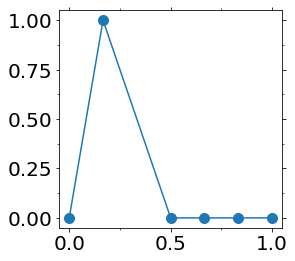

tensor([[1., 1., 0., 0., 0., 1.],
        [1., 1., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 0.],
        [0., 0., 0., 1., 1., 1.],
        [1., 0., 0., 0., 1., 1.]])


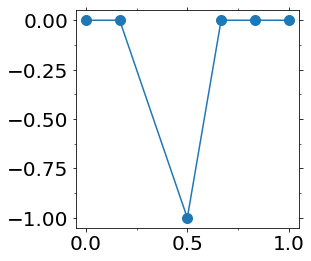

dataset_train: DataBatch(x=[6, 1], edge_index=[2, 16], y=[6, 2], batch=[6], ptr=[2])
dataset_test: DataBatch(x=[6, 1], edge_index=[2, 16], y=[6, 2], batch=[6], ptr=[2])
tensor([[0.0000],
        [0.1667],
        [0.5000],
        [0.6667],
        [0.8333],
        [1.0000]])
tensor([[ 0.,  0.],
        [ 1.,  0.],
        [ 0., -1.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.]])
mkdir: best_model: File exists
Epoch 0, Training Loss: 1.888e-01, Validation Loss: 1.851e-01
Epoch 1000, Training Loss: 9.001e-02, Validation Loss: 8.996e-02
Epoch 2000, Training Loss: 3.646e-02, Validation Loss: 3.643e-02
Epoch 3000, Training Loss: 1.526e-02, Validation Loss: 1.525e-02
Epoch 4000, Training Loss: 7.771e-03, Validation Loss: 7.760e-03
Epoch 5000, Training Loss: 3.829e-03, Validation Loss: 3.828e-03
Epoch 6000, Training Loss: 1.798e-03, Validation Loss: 1.796e-03
Epoch 7000, Training Loss: 9.820e-04, Validation Loss: 9.820e-04
Epoch 8000, Training Loss: 4.857e-04, Validation Loss

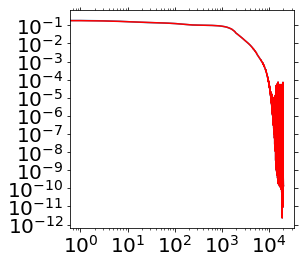

In [10]:
def main(): 
    # Check if GPU is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')
    
    # Check if GPUs are available
    if torch.cuda.is_available():
        # Get the number of available GPUs
        num_gpus = torch.cuda.device_count()
        print(f"{num_gpus} GPU(s) available")

        # Assert that at least one GPU is allocated
        assert num_gpus > 0, "No GPUs available. Please check your CUDA installation."

        # Print information about each GPU
        for i in range(num_gpus):
            gpu_name = torch.cuda.get_device_name(i)
            print(f"GPU {i}: {gpu_name}")
    else:
        print("No GPUs available. Please check your CUDA installation.")

    gnn = GraphNet(
                     ntrain     = eval(confParser['gnn']['ntrain']),
                     c_in       = 1,
                     c_hidden   = 64,
                     c_out      = 2,
                     num_layers = 2,
                     num_epochs = 20000,
                     noise_std  = 0.0,
                     lr         = 0.001,
                     verbose    = True 
                ).to(device)  # Move model to GPU

    gnn.Parse( path  = confParser['gnn']['input_path'],
                 nruns = eval(confParser['gnn']['nruns']))
    
    #--- build dataset based on the input catalogs
    gnn.DataBuilder2nd()
    
    # Define optimizer and loss function
    optimizer = optim.Adam(gnn.parameters(), lr=gnn.lr)
    criterion = nn.MSELoss()

    # training loop
    training_loss_hist   = []
    validation_loss_hist = []
    best_loss = np.inf
    print(gnn.dataset_test.x)
    print(gnn.dataset_test.y)
    !mkdir best_model
    for epoch in range( gnn.num_epochs ):
        optimizer.zero_grad()
        predicted_displacements = gnn(gnn.dataset_train.x.to(device), gnn.dataset_train.edge_index.to(device))
        training_loss              = criterion(predicted_displacements, gnn.dataset_train.y.to(device))
        training_loss.backward()
        optimizer.step()
        training_loss_hist += [training_loss.detach().cpu().numpy()]  # Move loss back to CPU

        #--- validation loss
        gnn.eval()
        with torch.no_grad():  # Disable gradient calculation
                predicted_displacements = gnn(gnn.dataset_test.x.to(device), gnn.dataset_test.edge_index.to(device))
                validation_loss         = criterion(predicted_displacements, gnn.dataset_test.y.to(device))

                validation_loss_hist += [validation_loss.cpu().numpy()]  # Move loss back to CPU

        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Training Loss: {training_loss.item():4.3e}, Validation Loss: {validation_loss.item():4.3e}')

            # Update best_loss if validation loss improves and save the model
#             best_loss = GraphNet.save_best_model(gnn, optimizer, 
#                                         epoch, training_loss.detach().cpu().numpy(), best_loss, 
#                                         'best_model/best_model.pth')

    #--- plot loss vs epoch
    !mkdir png
    ax = utl.PltErr(None,None,Plot=False)
    utl.PltErr(range(gnn.num_epochs),training_loss_hist,
               attrs={'fmt':'-','color':'C0'},
               ax=ax,Plot=False
          )
    utl.PltErr(range(gnn.num_epochs),validation_loss_hist,
               attrs={'fmt':'-','color':'red'},
              xscale='log',yscale='log',
               title='png/loss.png',
               Plot=False,
               ax=ax
          )
    return gnn.dataset_train, gnn.dataset_test


#data_train, data_test = main()


In [30]:
def make_prediction(model, data, title):
    ax = utl.PltErr(None,None,Plot=False)
    u_pred = model(data.x, data.edge_index)
        
    u_pred = u_pred.cpu().detach().numpy()
    u_act  = data.y.cpu()

    colors='black red green'.split()
    for idime in range(2):
        utl.PltErr(u_act[:,idime],u_pred[:,idime],
               attrs={'fmt':'x','color':colors[idime]},
              ax=ax, Plot=False,
              )

    utl.PltErr( None,None,
               Plot=False,
    ax=ax,
            xlim=(-2,2),ylim=(-2,2),
               title=title
              )
    
def main(data_train, data_test):
# Example usage
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')
    model = torch.load('best_model/best_model.pth').to(device)
    make_prediction(model, data_train.to(device), title='png/disp_train.png')
    make_prediction(model, data_test.to(device), title='png/disp_test.png')

#main(data_train, data_test)

### main

In [ ]:
def main(): 
    # Check if GPU is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')
    
    # Check if GPUs are available
    if torch.cuda.is_available():
        # Get the number of available GPUs
        num_gpus = torch.cuda.device_count()
        print(f"{num_gpus} GPU(s) available")

        # Assert that at least one GPU is allocated
        assert num_gpus > 0, "No GPUs available. Please check your CUDA installation."

        # Print information about each GPU
        for i in range(num_gpus):
            gpu_name = torch.cuda.get_device_name(i)
            print(f"GPU {i}: {gpu_name}")
    else:
        print("No GPUs available. Please check your CUDA installation.")

    gnn = GraphNet(
                     ntrain     = eval(confParser['gnn']['ntrain']),
                     c_in       = eval(confParser['gnn']['c_in']),
                     c_hidden   = eval(confParser['gnn']['c_hidden']),
                     c_out      = eval(confParser['gnn']['c_out']),
                     num_layers = eval(confParser['gnn']['num_layers']),
                     num_epochs = eval(confParser['gnn']['num_epochs']),
                     noise_std  = eval(confParser['gnn']['noise_std']),
                     lr         = eval(confParser['gnn']['lr']),
                     verbose    = True 
                ).to(device)  # Move model to GPU

    gnn.Parse( path  = confParser['gnn']['input_path'],
                 nruns = eval(confParser['gnn']['nruns']))
    
    #--- plot transition paths
#     gnn.PrintOvito()
    
    #--- build dataset based on the input catalogs
    gnn.DataBuilder()
    
    # Define optimizer and loss function
    optimizer = optim.Adam(gnn.parameters(), lr=gnn.lr)
    criterion = nn.MSELoss()

    # training loop
    training_loss_hist   = []
    validation_loss_hist = []
    best_loss = np.inf
    !mkdir best_model
    for epoch in range( gnn.num_epochs ):
        optimizer.zero_grad()
        predicted_displacements = gnn(gnn.dataset_train.x.to(device), gnn.dataset_train.edge_index.to(device))
        training_loss              = criterion(predicted_displacements, gnn.dataset_train.y.to(device))
        training_loss.backward()
        optimizer.step()
        if epoch == 0:
            num_weights = 0
            for item in gnn.parameters():
                 num_weights += item.flatten().detach().cpu().numpy().shape[0]
            print('num_weights=',num_weights)

        training_loss_hist += [training_loss.detach().cpu().numpy()]  # Move loss back to CPU

        #--- validation loss
        gnn.eval()
        with torch.no_grad():  # Disable gradient calculation
                predicted_displacements = gnn(gnn.dataset_test.x.to(device), gnn.dataset_test.edge_index.to(device))
                validation_loss         = criterion(predicted_displacements, gnn.dataset_test.y.to(device))

                validation_loss_hist += [validation_loss.cpu().numpy()]  # Move loss back to CPU

        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Training Loss: {training_loss.item():4.3e}, Validation Loss: {validation_loss.item():4.3e}')

            # Update best_loss if validation loss improves and save the model
    best_loss = GraphNet.save_best_model(gnn, optimizer, 
                                epoch, training_loss.detach().cpu().numpy(), best_loss, 
                                'best_model/best_model.pth')

    #--- plot loss vs epoch
    !mkdir png
    ax = utl.PltErr(None,None,Plot=False)
    utl.PltErr(range(gnn.num_epochs),training_loss_hist,
               attrs={'fmt':'-','color':'C0'},
               ax=ax,Plot=False
          )
    utl.PltErr(range(gnn.num_epochs),validation_loss_hist,
               attrs={'fmt':'-','color':'red'},
              xscale='log',yscale='log',
               title='png/loss.png',
               Plot=False,
               ax=ax
          )
    return gnn.dataset_train, gnn.dataset_test


data_train, data_test = main()


Using device: cpu
No GPUs available. Please check your CUDA installation.


In [ ]:
def make_prediction(model, data, title):
    ax = utl.PltErr(None,None,Plot=False)
    u_pred = model(data.x, data.edge_index)
        
    u_pred = u_pred.cpu().detach().numpy()
    u_act  = data.y.cpu()
    ndime  = u_act.shape[ 1 ]
    
    for idime in range(ndime):
        utl.PltErr(u_act[:,idime],u_pred[:,idime],
               attrs={'fmt':'x'},
              ax=ax, Plot=False,
              )

    utl.PltErr( None,None,
               Plot=False,
    ax=ax,
            xlim=(-2,2),ylim=(-2,2),
               title=title
              )
    
def main(data_train, data_test):
# Example usage
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')
    model = torch.load('best_model/best_model.pth').to(device)
    make_prediction(model, data_train.to(device), title='png/disp_train.png')
    make_prediction(model, data_test.to(device), title='png/disp_test.png')

main(data_train, data_test)

In [ ]:



# class GraphNeuralNet(nn.Module):
#     def __init__(self, input_dim, hidden_dims, output_dims, activation):
#         super(GraphNeuralNet, self).__init__()
#         self.output_dims = output_dims
#         self.fc1 = nn.Linear(input_dim, hidden_dims[0])
#         self.hidden_layers = nn.ModuleList()
#         for i in range(len(hidden_dims) - 1):
#             self.hidden_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
#         self.fc_out = nn.ModuleList([nn.Linear(hidden_dims[-1], dim) for dim in output_dims])
#         self.activation = activation

#     def forward(self, x, adj_matrices):
#         x = self.activation(self.fc1(x))
#         for hidden_layer in self.hidden_layers:
#             x = self.activation(hidden_layer(x))
#         outputs = []
#         for adj_matrix in adj_matrices:
#             hidden = torch.matmul(adj_matrix, x)
#             for fc_out in self.fc_out:
#                 outputs.append(fc_out(hidden))
#         return outputs




    







    

In [ ]:
# def main(): # Example usage
#     input_dim = eval(confParser['gnn']['input_dim']) #3  # Dimensionality of atom positions (e.g., x, y, z coordinates)
#     hidden_dim = eval(confParser['gnn']['hidden_dim']) #[64]  # Dimensionality of hidden layers
#     output_dims = eval(confParser['gnn']['output_dims']) #[3]  # Dimensionality of displacement vectors for each snapshot
#     activation = eval(confParser['gnn']['activation']) #nn.ReLU() #nn.Identity()) #F.relu)
#     lr = eval(confParser['gnn']['lr'])# 1.0e-4
#     ntrain = eval(confParser['gnn']['ntrain'])#100
#     num_epochs = eval(confParser['gnn']['num_epochs'])#20000
#     noise_std   = eval(confParser['gnn']['noise_std'])#0.1

#     num_snapshots = len( transition_paths )
#     snapshots     = range(num_snapshots)

#     model = GraphNeuralNet(input_dim, hidden_dim, output_dims,activation) #


#     # Define optimizer and loss function
#     optimizer = optim.Adam(model.parameters(), lr=lr)
#     criterion = nn.MSELoss()

#     # Example training data
#     num_atoms = [ len(transition_paths[ i ]['id']) for i in snapshots ]
#     input_data = [torch.from_numpy( np.c_[pd.DataFrame(transition_paths[ i ])['x y z'.split()]] ).float() for i in snapshots]  



#     # Example target data (displacement vectors for each snapshot and each path)
#     target_displacements = [torch.from_numpy( np.c_[pd.DataFrame(transition_paths[ i ])['ux_fin uy_fin uz_fin'.split()]] ).float() for i in snapshots for dim in output_dims]


#     # Augment the dataset to have order 100 snapshots
#     augmented_input_data = []
#     augmented_target_displacements = []
#     input_data_tensor = torch.stack(input_data)
#     ntrain_initial = input_data_tensor.shape[0]*input_data_tensor.shape[1]
#     n_repeat = np.max([1,int(ntrain/ntrain_initial)])

#     for _ in range(n_repeat):  # Repeat the augmentation process 10 times
#         augmented_input, augmented_target = augment_data(input_data, target_displacements, noise_std)
#         augmented_input_data.extend(augmented_input)
#         augmented_target_displacements.extend(augmented_target)

#     adj_matrices = compute_adjacency_matrices(augmented_input_data, rcut=3.0) #[torch.randint(0, 2, (num_atoms[i], num_atoms[i])).float() for i in range(num_snapshots)]  # Random adjacency matrices for each snapshot



#     # Concatenate input data along a new dimension to form a single tensor
#     input_data_tensor = torch.stack(augmented_input_data)
#     print('input_data_tensor.shape:',input_data_tensor.shape)

#     # Standardize the augmented input data
#     mean = input_data_tensor.mean(dim=(0, 1))
#     std = input_data_tensor.std(dim=(0, 1))
#     standardized_input_data = [standardize_data(data, mean, std) for data in augmented_input_data]


#     # Convert input data to tensors
#     #input_data_tensor = torch.stack(augmented_input_data)
#     target_displacements_tensor = torch.stack(augmented_target_displacements)

#     total_loss_hist = []
#     for epoch in range(num_epochs):
#         optimizer.zero_grad()
#         predicted_displacements = model(input_data_tensor, adj_matrices)
#     #    predicted_displacements_tensor = torch.stack( predicted_displacements )
#         losses = []
#         for indx, i in enumerate(snapshots):
#             pred = predicted_displacements[ indx ][ indx ]
#             snapshot_losses = criterion(pred, augmented_target_displacements[indx])
#     #        snapshot_losses = [criterion(pred, augmented_target_displacements[indx]) for pred in predicted_displacements[indx]]
#     #        pdb.set_trace()
#             losses.append(snapshot_losses)
#     #        losses.extend(snapshot_losses)
#     #    loss = criterion(predicted_displacements_tensor, target_displacements_tensor)
#         total_loss = sum(losses)
#         total_loss.backward()
#     #    loss.backward()
#         optimizer.step()
#         total_loss_hist += [total_loss.detach().numpy()]
#         if epoch % 100 == 0:
#             print(f'Epoch {epoch}, Total Loss: {total_loss.item()}')

# #main()

In [ ]:
# data

In [ ]:
# ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d',)

# batch_indx = 0
# filtr = data.batch == batch_indx

# xyz = data.x 
# adj_mat = data.edge_index.T


# ax.plot(xyz[filtr][:,0],xyz[filtr][:,1],xyz[filtr][:,2],
#         '.', ms=20,
#         )

# min_node_indx = data.ptr[ batch_indx ]
# max_node_indx = data.ptr[ batch_indx + 1 ]
# for nodes in (adj_mat):
#     i = nodes[0]
#     j = nodes[1]
#     if i < min_node_indx or i >= max_node_indx: 
#         continue
#     if j < min_node_indx or j >= max_node_indx: 
#         continue
#     ax.plot([xyz[i,0],xyz[j,0]],[xyz[i,1],xyz[j,1]],[xyz[i,2],xyz[j,2]],
#             '-', color='black',
#             )

#     u = data.y

# ax.plot(([xyz[filtr][17,0],xyz[filtr][17,0]+u[filtr][17,0]]),
#         ([xyz[filtr][17,1],xyz[filtr][17,1]+u[filtr][17,1]]),
#         ([xyz[filtr][17,2],xyz[filtr][17,2]+u[filtr][17,2]]),
#         '-', color='red',
#         )


## mpnn

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# import numpy as np
# import pandas as pd

# class MPNN(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super(MPNN, self).__init__()
#         self.fc1 = nn.Linear(input_dim, hidden_dim)
#         self.fc2 = nn.Linear(hidden_dim, output_dim)

#     def message_passing_layer(self, x, adj_matrices):
#         # Ensure adj_matrices is a list of tensors
#         adj_matrices = [adj.unsqueeze(0) for adj in adj_matrices]

#         # Expand node features to include neighboring node features
# #        expanded_x = [torch.matmul(adj.unsqueeze(0), x.unsqueeze(0)).squeeze(0) for adj in adj_matrices]
#         expanded_x = [torch.matmul(adj,yy) for adj, yy in zip(adj_matrices,x)]
# #        expanded_x = [torch.matmul(adj.unsqueeze(0), adj).squeeze(0) for adj in adj_matrices]

#         # Concatenate node features with neighboring node features
#         pdb.set_trace()
#         concatenated_x = [torch.cat((x, exp_x), dim=1) for exp_x in expanded_x]

#         # Apply linear transformation
#         transformed_x = [self.fc1(cat_x) for cat_x in concatenated_x]

#         # Apply activation function
#         x = [F.relu(trans_x) for trans_x in transformed_x]

#         return x


#     def readout_layer(self, x):
#         # Concatenate tensors in the list along the batch dimension
#         concatenated_x = torch.stack(x, dim=0)

#         # Apply global pooling operation (e.g., mean or sum) along the batch dimension
#         return torch.mean(concatenated_x, dim=0)

#     def forward(self, x, adj_matrices):
#         x = self.message_passing_layer(x, adj_matrices)
#         output = self.readout_layer(x)
#         return output

# # Example usage
# input_dim = 3  # Dimensionality of atom positions (e.g., x, y, z coordinates)
# hidden_dim = 64  # Dimensionality of hidden layers
# output_dim = 3  # Dimensionality of displacement vectors for each snapshot

# # Create model instance
# model = MPNN(input_dim, hidden_dim, output_dim)

# # Define optimizer and loss function
# optimizer = optim.Adam(model.parameters(), lr=1.0e-4)
# criterion = nn.MSELoss()

# # Example training data
# # Assuming input_data is a list of tensors containing initial positions for each snapshot
# # Assuming adj_matrices is a list of adjacency matrices for each snapshot
# # Assuming target_displacements is a list of tensors containing displacement vectors for each snapshot
# # You need to replace these with your actual data
# input_data = [torch.randn(10, input_dim).float() for _ in range(10)]  # Example random initial positions
# adj_matrices = [torch.randint(0, 2, (10, 10)).float() for _ in range(10)]  # Example random adjacency matrices
# target_displacements = [torch.randn(10, output_dim) for _ in range(10)]  # Example random target displacements

# # Training loop
# num_epochs = 1000
# for epoch in range(num_epochs):
#     optimizer.zero_grad()
#     predicted_displacements = model(input_data, adj_matrices)
#     loss = criterion(predicted_displacements, target_displacements)
#     loss.backward()
#     optimizer.step()
#     if epoch % 100 == 0:
#         print(f'Epoch {epoch}, Loss: {loss.item()}')


## tf

In [ ]:
# import tensorflow as tf

# class GraphNeuralNetwork(tf.keras.Model):
#     def __init__(self, hidden_dim, output_dim):
#         super(GraphNeuralNetwork, self).__init__()
#         self.hidden_dim = hidden_dim
#         self.output_dim = output_dim
        
#         # Define layers
#         self.fc1 = tf.keras.layers.Dense(hidden_dim, activation='relu')
#         self.fc2 = tf.keras.layers.Dense(hidden_dim, activation='relu')
#         self.fc_out = tf.keras.layers.Dense(output_dim)

#     def call(self, x, adj_matrices):
#         # x: Node features (batch_size, num_nodes, input_dim)
#         # adj_matrices: Adjacency matrices (batch_size, num_nodes, num_nodes)
        
#         # Apply first fully connected layer
#         x = self.fc1(x)
        
#         # Iterate over adjacency matrices and update node features
#         for adj_matrix in adj_matrices:
#             x = tf.matmul(adj_matrix, x)
#             x = self.fc2(x)
        
#         # Apply output fully connected layer
#         output = self.fc_out(x)
        
#         return output

# def compute_adjacency_matrices_tf(input_data, rcut):
#     adj_matrices = []
    
#     for positions in input_data:
#         num_atoms = positions.shape[0]
#         adj_matrix = np.zeros(num_atoms*num_atoms).reshape((num_atoms, num_atoms))
        
#         for i in range(num_atoms):
#             for j in range(i + 1, num_atoms):
#                 distance = torch.norm(positions[i] - positions[j])
#                 if distance <= rcut:
#                     adj_matrix[i, j] = 1
#                     adj_matrix[j, i] = 1
#             assert adj_matrix[i,:].sum() > 0, 'dangling node : increase the cutoff!'
#         adj_matrices.append(adj_matrix)
    
#     #--- assert no 
#     return np.c_[adj_matrices]



# def main():
#     # Example usage
#     hidden_dim = 32  # Dimensionality of hidden layers
#     output_dim = 3  # Dimensionality of output vectors
#     snapshots = [0] #range(len(transition_paths))

#     model = GraphNeuralNetwork(hidden_dim, output_dim)

#     # Define optimizer and loss function
#     optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
#     loss_fn = tf.keras.losses.MeanSquaredError()

#     # Generate dummy input data and adjacency matrices
# #     batch_size = 2
# #     num_nodes = 10
#     input_dim = 3

#     #x = tf.random.normal((batch_size, num_nodes, input_dim))
#     x = np.c_[[np.c_[pd.DataFrame(transition_paths[ i ])['x y z'.split()]] for i in snapshots]]
#     x = tf.convert_to_tensor(x,dtype=tf.float32)

#     #adj_matrices = tf.random.uniform((batch_size, num_nodes, num_nodes)) # for _ in range(2)]  # Example with 2 adjacency matrices
#     input_data = [torch.from_numpy( np.c_[pd.DataFrame(transition_paths[ i ])['x y z'.split()]] ).float() for i in snapshots]  
#     adj_matrices = compute_adjacency_matrices_tf(torch.stack(input_data), rcut=3.0)
#     adj_matrices = tf.convert_to_tensor(adj_matrices,dtype=tf.float32)

#     # Example target data
#     #target = tf.random.normal((batch_size, num_nodes, output_dim))
#     target = np.c_[[np.c_[pd.DataFrame(transition_paths[ i ])['ux_fin uy_fin uz_fin'.split()]] for i in snapshots]]
#     target = tf.convert_to_tensor(target,dtype=tf.float32)


#     # Training loop
#     total_loss_hist = []
#     num_epochs = 5000 #100000
#     for epoch in range(num_epochs):
#         with tf.GradientTape() as tape:
#             predictions = model(x, adj_matrices)
#     #         pdb.set_trace()
#             loss = loss_fn(target, predictions)

#         gradients = tape.gradient(loss, model.trainable_variables)
#         optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
#         if epoch == 0:
#             loss_min = loss.numpy()
#             best_model = model
#         total_loss_hist.append(loss.numpy())
#         if epoch % 100 == 0: 
#             print('Epoch %s, Loss: %e'%(epoch,loss.numpy()))
#             if loss.numpy() < loss_min:
#                 loss_min = loss.numpy()
#                 best_model = model     
#     print('min loss:%e'%loss_min)
#     return best_model, num_epochs, total_loss_hist

# #model, num_epochs, total_loss_hist = main()

## pytorch

In [ ]:
# # Standard libraries
# import os

# # For downloading pre-trained models
# import urllib.request
# from urllib.error import HTTPError

# # PyTorch Lightning
# import lightning as L

# # PyTorch
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim

# # PyTorch geometric
# import torch_geometric
# import torch_geometric.data as geom_data
# import torch_geometric.nn as geom_nn

# # PL callbacks
# from lightning.pytorch.callbacks import ModelCheckpoint
# from torch import Tensor

# AVAIL_GPUS = min(1, torch.cuda.device_count())
# BATCH_SIZE = 256 if AVAIL_GPUS else 64
# # Path to the folder where the datasets are/should be downloaded
# DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
# # Path to the folder where the pretrained models are saved
# CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/GNNs/")

# # Setting the seed
# L.seed_everything(42)

# # Ensure that all operations are deterministic on GPU (if used) for reproducibility
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

In [ ]:
# # Github URL where saved models are stored for this tutorial
# base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial7/"
# # Files to download
# pretrained_files = ["NodeLevelMLP.ckpt", "NodeLevelGNN.ckpt", "GraphLevelGraphConv.ckpt"]

# # Create checkpoint path if it doesn't exist yet
# os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# # For each file, check whether it already exists. If not, try downloading it.
# for file_name in pretrained_files:
#     file_path = os.path.join(CHECKPOINT_PATH, file_name)
#     if "/" in file_name:
#         os.makedirs(file_path.rsplit("/", 1)[0], exist_ok=True)
#     if not os.path.isfile(file_path):
#         file_url = base_url + file_name
#         print("Downloading %s..." % file_url)
#         try:
#             urllib.request.urlretrieve(file_url, file_path)
#         except HTTPError as e:
#             print(
#                 "Something went wrong. Please try to download the file from the GDrive folder,"
#                 " or contact the author with the full output including the following error:\n",
#                 e,
#             )

In [ ]:
# class GCNLayer(nn.Module):
#     def __init__(self, c_in, c_out):
#         super().__init__()
#         self.projection = nn.Linear(c_in, c_out)

#     def forward(self, node_feats, adj_matrix):
#         """Forward.

#         Args:
#             node_feats: Tensor with node features of shape [batch_size, num_nodes, c_in]
#             adj_matrix: Batch of adjacency matrices of the graph. If there is an edge from i to j,
#                          adj_matrix[b,i,j]=1 else 0. Supports directed edges by non-symmetric matrices.
#                          Assumes to already have added the identity connections.
#                          Shape: [batch_size, num_nodes, num_nodes]
#         """
#         # Num neighbours = number of incoming edges
#         num_neighbours = adj_matrix.sum(dim=-1, keepdims=True)
#         node_feats = self.projection(node_feats)
#         node_feats = torch.bmm(adj_matrix, node_feats)
#         node_feats = node_feats / num_neighbours
#         return node_feats

In [ ]:
# node_feats = torch.arange(8, dtype=torch.float32).view(1, 4, 2)
# adj_matrix = Tensor([[[1, 1, 0, 0], [1, 1, 1, 1], [0, 1, 1, 1], [0, 1, 1, 1]]])

# print("Node features:\n", node_feats)
# print("\nAdjacency matrix:\n", adj_matrix)

In [ ]:
# layer = GCNLayer(c_in=2, c_out=2)
# layer.projection.weight.data = Tensor([[1.0, 0.0], [0.0, 1.0]])
# layer.projection.bias.data = Tensor([0.0, 0.0])

# with torch.no_grad():
#     out_feats = layer(node_feats, adj_matrix)

# print("Adjacency matrix", adj_matrix)
# print("Input features", node_feats)
# print("Output features", out_feats)

In [ ]:


# cora_dataset = torch_geometric.datasets.Planetoid(root=DATASET_PATH, name="Cora")


In [ ]:
# cora_dataset[0]

In [ ]:
# # Small function for printing the test scores
# def print_results(result_dict):
#     if "train" in result_dict:
#         print("Train accuracy: %4.2f%%" % (100.0 * result_dict["train"]))
#     if "val" in result_dict:
#         print("Val accuracy:   %4.2f%%" % (100.0 * result_dict["val"]))
#     print("Test accuracy:  %4.2f%%" % (100.0 * result_dict["test"]))

In [ ]:
# tu_dataset = torch_geometric.datasets.TUDataset(root=DATASET_PATH, name="MUTAG")


In [ ]:
# print("Data object:", tu_dataset.data)
# print("Length:", len(tu_dataset))
# print("Average label: %4.2f" % (tu_dataset.data.y.float().mean().item()))


In [ ]:
# torch.manual_seed(42)
# tu_dataset.shuffle()
# train_dataset = tu_dataset[:150]
# test_dataset = tu_dataset[150:]


In [ ]:
# graph_train_loader = geom_data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# graph_val_loader = geom_data.DataLoader(test_dataset, batch_size=BATCH_SIZE)  # Additional loader for a larger datasets
# graph_test_loader = geom_data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
# batch = next(iter(graph_test_loader))
# print("Batch:", batch)
# print("Labels:", batch.y[:10])
# print("Batch indices:", batch.batch[:40])

In [ ]:
# class GNNModel(nn.Module):
#     def __init__(
#         self,
#         c_in,
#         c_hidden,
#         c_out,
#         num_layers=2,
#         layer_name="GCN",
#         dp_rate=0.1,
#         **kwargs,
#     ):
#         """GNNModel.

#         Args:
#             c_in: Dimension of input features
#             c_hidden: Dimension of hidden features
#             c_out: Dimension of the output features. Usually number of classes in classification
#             num_layers: Number of "hidden" graph layers
#             layer_name: String of the graph layer to use
#             dp_rate: Dropout rate to apply throughout the network
#             kwargs: Additional arguments for the graph layer (e.g. number of heads for GAT)
#         """
#         super().__init__()
#         gnn_layer_by_name = {"GCN": geom_nn.GCNConv, "GAT": geom_nn.GATConv, "GraphConv": geom_nn.GraphConv}
#         gnn_layer = gnn_layer_by_name[layer_name]

#         layers = []
#         in_channels, out_channels = c_in, c_hidden
#         for l_idx in range(num_layers - 1):
#             layers += [
#                 gnn_layer(in_channels=in_channels, out_channels=out_channels, **kwargs),
#                 nn.ReLU(inplace=True),
#                 nn.Dropout(dp_rate),
#             ]
#             in_channels = c_hidden
#         layers += [gnn_layer(in_channels=in_channels, out_channels=c_out, **kwargs)]
#         self.layers = nn.ModuleList(layers)

#     def forward(self, x, edge_index):
#         """Forward.

#         Args:
#             x: Input features per node
#             edge_index: List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)
#         """
#         for layer in self.layers:
#             # For graph layers, we need to add the "edge_index" tensor as additional input
#             # All PyTorch Geometric graph layer inherit the class "MessagePassing", hence
#             # we can simply check the class type.
#             if isinstance(layer, geom_nn.MessagePassing):
# #                 pdb.set_trace()
#                 x = layer(x, edge_index)
#             else:
#                 x = layer(x)
#         return x

### toturial

In [ ]:

# def main(): # Example usage

    
#     c_in=input_dim=3
#     c_hidden = 16
#     hidden_dim = [c_hidden]
#     c_out  = 3
#     output_dims=[c_out]
#     num_layers = 2
#     ntrain = 100
#     num_epochs=100
#     noise_std=0.001
#     lr=1e-4
#     batch_size = 12  # or any desired batch size


#     num_snapshots = len( transition_paths )
#     print('num_snapshots=',num_snapshots)
#     snapshots     = range(num_snapshots)

# #     model = GraphNeuralNet(input_dim, hidden_dim, output_dims,activation) #
#     model = GNNModel(c_in,
#         c_hidden,
#         c_out,
#         num_layers=num_layers,
# )


#     # Define optimizer and loss function
#     optimizer = optim.Adam(model.parameters(), lr=lr)
#     criterion = nn.MSELoss()

#     # Example training data
#     input_data = [torch.from_numpy( np.c_[pd.DataFrame(transition_paths[ i ])['x y z'.split()]] ).float() for i in snapshots]  




    



#     # Example target data (displacement vectors for each snapshot and each path)
#     target_displacements = [torch.from_numpy( np.c_[pd.DataFrame(transition_paths[ i ])['ux_fin uy_fin uz_fin'.split()]] ).float() for i in snapshots for dim in output_dims]


#     # Augment the dataset to have order 100 snapshots
#     augmented_input_data = []
#     augmented_target_displacements = []
#     input_data_tensor = torch.stack(input_data)
#     ntrain_initial = input_data_tensor.shape[0]*input_data_tensor.shape[1]
#     n_repeat = np.max([1,int(ntrain/ntrain_initial)])

#     for _ in range(n_repeat):  # Repeat the augmentation process 10 times
#         augmented_input, augmented_target = augment_data(input_data, target_displacements, noise_std)
#         augmented_input_data.extend(augmented_input)
#         augmented_target_displacements.extend(augmented_target)

#     adj_matrices = torch.stack(compute_adjacency_matrices(augmented_input_data, rcut=3.0)) 
    


#     # Concatenate input data along a new dimension to form a single tensor
#     input_data_tensor = torch.stack(augmented_input_data)
#     print('input_data_tensor.shape:',input_data_tensor.shape)

#     # Standardize the augmented input data
#     mean = input_data_tensor.mean(dim=(0, 1))
#     std = input_data_tensor.std(dim=(0, 1))
#     standardized_input_data = [standardize_data(data, mean, std) for data in augmented_input_data]


#     # Convert input data to tensors
#     target_displacements_tensor = torch.stack(augmented_target_displacements)
    
    
    
    
#     # Concatenate nodes and edges for each graph
#     graphs = []
#     for i in range(len(input_data)):
#         x = input_data_tensor[i]  # Node features
#         edge_index = adj_matrices[i].nonzero().t()  # Edge indices
#         y = target_displacements_tensor[i]  # Target displacements

#         # Create a Data object for each graph
#         data = Data(x=x, edge_index=edge_index, y=y)
#         graphs.append(data)
#     # Create a single large graph by concatenating Data objects
#     large_graph = torch_geometric.data.Batch.from_data_list(graphs)

#     # Define batch size and create DataLoader
#     loader = DataLoader(large_graph, batch_size=batch_size, shuffle=True)

# #     # Accessing batches in the DataLoader
#     data=loader.dataset #next(iter(loader))
# #     pdb.set_trace()
# #    for data in loader:
# #    print(data)


#     total_loss_hist = []
#     for epoch in range(num_epochs):
#         optimizer.zero_grad()
#         predicted_displacements = model(data.x, data.edge_index)
#         total_loss = criterion(predicted_displacements,data.y )
#         total_loss.backward()
#     #    loss.backward()
#         optimizer.step()
#         total_loss_hist += [total_loss.detach().numpy()]
#         if epoch % 100 == 0:
#             print(f'Epoch {epoch}, Total Loss: {total_loss.item()}')

#     return model, num_epochs, total_loss_hist, data



# gnn_layer_by_name = {"GCN": geom_nn.GCNConv, "GAT": geom_nn.GATConv, "GraphConv": geom_nn.GraphConv}

# model, num_epochs, total_loss_hist, data = main()




In [ ]:
# class GraphGNNModel(nn.Module):
#     def __init__(self, c_in, c_hidden, c_out, dp_rate_linear=0.5, **kwargs):
#         """GraphGNNModel.

#         Args:
#             c_in: Dimension of input features
#             c_hidden: Dimension of hidden features
#             c_out: Dimension of output features (usually number of classes)
#             dp_rate_linear: Dropout rate before the linear layer (usually much higher than inside the GNN)
#             kwargs: Additional arguments for the GNNModel object
#         """
#         super().__init__()
#         self.GNN = GNNModel(c_in=c_in, c_hidden=c_hidden, c_out=c_hidden, **kwargs)  # Not our prediction output yet!
#         self.head = nn.Sequential(nn.Dropout(dp_rate_linear), nn.Linear(c_hidden, c_out))

#     def forward(self, x, edge_index, batch_idx):
#         """Forward.

#         Args:
#             x: Input features per node
#             edge_index: List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)
#             batch_idx: Index of batch element for each node
#         """
#         x = self.GNN(x, edge_index)
#         x = geom_nn.global_mean_pool(x, batch_idx)  # Average pooling
#         x = self.head(x)
#         return x

In [ ]:
# class GraphLevelGNN(L.LightningModule):
#     def __init__(self, **model_kwargs):
#         super().__init__()
#         # Saving hyperparameters
#         self.save_hyperparameters()

#         self.model = GraphGNNModel(**model_kwargs)
#         self.loss_module = nn.BCEWithLogitsLoss() if self.hparams.c_out == 1 else nn.CrossEntropyLoss()

#     def forward(self, data, mode="train"):
#         x, edge_index, batch_idx = data.x, data.edge_index, data.batch
#         x = self.model(x, edge_index, batch_idx)
#         x = x.squeeze(dim=-1)

#         if self.hparams.c_out == 1:
#             preds = (x > 0).float()
#             data.y = data.y.float()
#         else:
#             preds = x.argmax(dim=-1)
#         loss = self.loss_module(x, data.y)
#         acc = (preds == data.y).sum().float() / preds.shape[0]
#         return loss, acc

#     def configure_optimizers(self):
#         # High lr because of small dataset and small model
#         optimizer = optim.AdamW(self.parameters(), lr=1e-2, weight_decay=0.0)
#         return optimizer

#     def training_step(self, batch, batch_idx):
#         loss, acc = self.forward(batch, mode="train")
#         self.log("train_loss", loss)
#         self.log("train_acc", acc)
#         return loss

#     def validation_step(self, batch, batch_idx):
#         _, acc = self.forward(batch, mode="val")
#         self.log("val_acc", acc)

#     def test_step(self, batch, batch_idx):
#         _, acc = self.forward(batch, mode="test")
#         self.log("test_acc", acc)

In [ ]:
# def train_graph_classifier(model_name, **model_kwargs):
#     L.seed_everything(42)

#     # Create a PyTorch Lightning trainer with the generation callback
#     root_dir = os.path.join(CHECKPOINT_PATH, "GraphLevel" + model_name)
#     os.makedirs(root_dir, exist_ok=True)
#     trainer = L.Trainer(
#         default_root_dir=root_dir,
#         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
# #        accelerator="cuda",
# #        devices=AVAIL_GPUS,
#         max_epochs=500,
#         enable_progress_bar=False,
#     )
#     trainer.logger._default_hp_metric = None

#     # Check whether pretrained model exists. If yes, load it and skip training
#     pretrained_filename = os.path.join(CHECKPOINT_PATH, "GraphLevel%s.ckpt" % model_name)
#     if os.path.isfile(pretrained_filename):
#         print("Found pretrained model, loading...")
#         model = GraphLevelGNN.load_from_checkpoint(pretrained_filename)
#     else:
#         L.seed_everything(42)
#         model = GraphLevelGNN(
#             c_in=tu_dataset.num_node_features,
#             c_out=1 if tu_dataset.num_classes == 2 else tu_dataset.num_classes,
#             **model_kwargs,
#         )
#         trainer.fit(model, graph_train_loader, graph_val_loader)
#         model = GraphLevelGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

#     # Test best model on validation and test set
#     train_result = trainer.test(model, dataloaders=graph_train_loader, verbose=False)
#     test_result = trainer.test(model, dataloaders=graph_test_loader, verbose=False)
#     result = {"test": test_result[0]["test_acc"], "train": train_result[0]["test_acc"]}
#     return model, result

In [ ]:
# model, result = train_graph_classifier(
#     model_name="GraphConv", c_hidden=256, layer_name="GraphConv", num_layers=3, dp_rate_linear=0.5, dp_rate=0.0
# )

In [ ]:
# def make_prediction(model, input_data, adj_matrices, target_displacements):
#     ax = utl.PltErr(None,None,Plot=False)
#     predicted_displacements = model(input_data, adj_matrices)
#     for i_snapshot,u_pred in enumerate(predicted_displacements):
        
#         u_act  = target_displacements[i_snapshot]

#         colors='black red green'.split()
#         for idime in range(3):
#             utl.PltErr(u_act[:,idime],u_pred[:,idime],
#                    attrs={'fmt':'x','color':colors[idime]},
#                   ax=ax, Plot=False,
#                   )

#         utl.PltErr( None,None,
#                    Plot=False,
#         ax=ax,
#                 #xlim=(-2,2),ylim=(-2,2),
#                    title='png/disp.png'
#                   )


# snapshots = [0] #range(len(transition_paths))
# x = np.c_[[np.c_[pd.DataFrame(transition_paths[ i ])['x y z'.split()]] for i in snapshots]]
# x = tf.convert_to_tensor(x,dtype=tf.float32)

# #adj_matrices = tf.random.uniform((batch_size, num_nodes, num_nodes)) # for _ in range(2)]  # Example with 2 adjacency matrices
# input_data = [torch.from_numpy( np.c_[pd.DataFrame(transition_paths[ i ])['x y z'.split()]] ).float() for i in snapshots]  
# adj_matrices = compute_adjacency_matrices(torch.stack(input_data), rcut=3.0)
# adj_matrices = tf.convert_to_tensor(adj_matrices,dtype=tf.float32)

# # Example target data
# #target = tf.random.normal((batch_size, num_nodes, output_dim))
# target = np.c_[[np.c_[pd.DataFrame(transition_paths[ i ])['ux_fin uy_fin uz_fin'.split()]] for i in snapshots]]
# target = tf.convert_to_tensor(target,dtype=tf.float32)


# make_prediction(model, x, adj_matrices, target)

